In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import commonutils
import models
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from dataclasses import dataclass
import prettyprinter as pp

from sklearn.cross_decomposition import PLSRegression
import warnings
import sys

from sklearn import preprocessing

from copy import deepcopy

In [2]:
@dataclass
class ModelResults:
    # predicted values
    y_pred: list = None
    y_pred_bestourmethod: list = None
    y_pred_bestinsidemethod: list = None
    # data related to full set
    fulldescriptors: list = None
    labels: list = None
    top_correlation: list = None
    # data realated to inside and our methods
    inside_methods_rmse: list = None
    bestinsidemethod_rmse: float = 0.0
    bestinsidemethod: str = None
    inside_methods_r2: list = None
    our_methods_rmse: dict = None
    bestourmethod_rmse: float = 0.0
    bestourmethod: str = None
    our_methods_r2: dict = None
    our_methods_name : list = None

def read_and_init (inrootdir, supersetnames, howmanydifs, methods, \
                   DEBUG=False):
    
    allvalues_perset = {}
    fullsetnames = []
    models_results = {}

    toberemoved = {}
    for super_setname in supersetnames:
        toberemoved[super_setname] = []
        allvalues_perset[super_setname] = []
        fullsetnames.append(super_setname)
        for i, setname in enumerate(supersetnames[super_setname]):
              print("Reading dataset: ", setname)
              rootdir = inrootdir + super_setname + "/" +setname
              labelsfilename = inrootdir + setname +"_labels.txt"
        
              values =\
                    commonutils.read_dataset(rootdir, labelsfilename, \
                                             howmanydifs, methods, \
                                             debug=DEBUG)
              
              if (values is None) or (len(values) <= 2):
                    print(setname + " No data found for this dataset")
                    print("")
                    toberemoved[super_setname].append(i)
              else:
                    fullsetname = super_setname+"_"+setname
                    fullsetnames.append(fullsetname)
                    allvalues_perset[fullsetname] = values  
                    print("Number of samples: ", len(allvalues_perset[fullsetname]))
                    print("Number of basic descriptors: ", len(allvalues_perset[fullsetname]))
              
                    allvalues_perset[super_setname] += allvalues_perset[fullsetname]
                    print("")

    for super_setname in toberemoved:
        for i in sorted(toberemoved[super_setname], reverse=True):
          del supersetnames[super_setname][i]
    
    allvalues_perset["Full"] = []
    for super_setname in supersetnames:
          allvalues_perset["Full"] += allvalues_perset[super_setname]  
    fullsetnames.append("Full")

    for setname in fullsetnames:
        models_results[setname] = ModelResults()

    return allvalues_perset, fullsetnames, models_results


In [3]:
warnings.simplefilter("ignore")
CORRCUT = 0.98

supersetnames = {"BARRIER_HEIGHTS" : \
                       ["BH76","BHDIV10","BHPERI",\
                        "BHROT27","INV24","PX13","WCPT18"] \
                    ,"INTRAMOLECULAR_INTERACTIONS" : \
                       ["ACONF","ICONF","IDISP","MCONF",\
                        "PCONF21","SCONF","UPU23"] , \
                    "SMALL_MOLECULES" :\
                        ["AL2X6","ALK8","ALKBDE10","BH76",\
                         "DC13","DIPCS10","FH51","G21EA",\
                         "G21IP","G2RC","HEAVYSB11","NBPRC",\
                         "PA26","RC21","SIE4x4","TAUT15",\
                         "W4-11","YBDE18"], \
                    "INTERMOLECULAR_INTERACTIONS" :\
                       ["ADIM6","AHB21","CARBHB12",\
                        "CHB6","HAL59","HEAVY28","IL16",\
                        "PNICO23","RG18","S22","S66","WATER27"] , \
                    "LARGE_SYSTEMS" :\
                        ["BSR36","C60ISO","CDIE20","DARC",\
                         "ISO34","ISOL24","MB16-43","PArel",\
                            "RSE43"]}    
howmanydifs = 3
methods = {"PBE" : ["Nuclear Repulsion  :", \
                        "One Electron Energy:", \
                        "Two Electron Energy:", \
                        "Potential Energy   :", \
                        "Kinetic Energy     :", \
                        "E(X)               :"  , \
                        "E(C)               :"  , \
                        "Dispersion correction", \
                        "FINAL SINGLE POINT ENERGY"], 
                "PBE0" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"] ,
                "ZORA" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"],
                "TPSSh" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"]
                }
# read all the data and initialize the data structures
rootdir = "../datasets/AllData/"   
allvalues_perset, fullsetnames, models_results = \
        read_and_init (rootdir, supersetnames, howmanydifs, methods, \
                       DEBUG=False)

Reading dataset:  BH76
BH76 No data found for this dataset

Reading dataset:  BHDIV10
Number of samples:  10
Number of basic descriptors:  10

Reading dataset:  BHPERI
Number of samples:  26
Number of basic descriptors:  26

Reading dataset:  BHROT27
Number of samples:  27
Number of basic descriptors:  27

Reading dataset:  INV24
Number of samples:  24
Number of basic descriptors:  24

Reading dataset:  PX13
Number of samples:  13
Number of basic descriptors:  13

Reading dataset:  WCPT18
Number of samples:  18
Number of basic descriptors:  18

Reading dataset:  ACONF
Number of samples:  15
Number of basic descriptors:  15

Reading dataset:  ICONF
Number of samples:  17
Number of basic descriptors:  17

Reading dataset:  IDISP
Number of samples:  6
Number of basic descriptors:  6

Reading dataset:  MCONF
Number of samples:  51
Number of basic descriptors:  51

Reading dataset:  PCONF21
Number of samples:  18
Number of basic descriptors:  18

Reading dataset:  SCONF
Number of samples:  

In [4]:
allfeatures = set()
for setname in fullsetnames:
    for val in allvalues_perset[setname]:
        for k in val:
            if k.find("energydiff") != -1:
                for f in val[k]:
                    allfeatures.add(f)
for setname in fullsetnames:
    models_results[setname].inside_methods_rmse = []
    models_results[setname].inside_methods_r2 = []
    models_results[setname].our_methods_rmse = {}
    models_results[setname].our_methods_r2 = {}
    
    models_results[setname].bestinsidemethod_rmse = float("inf")
    models_results[setname].bestinsidemethod = ""
    models_results[setname].bestourmethod_rmse = float("inf")
    models_results[setname].bestourmethod = ""
    models_results[setname].our_methods_name = []

    for methodid in range(howmanydifs):
        y_pred = []
        labels = []
        for val in allvalues_perset[setname]:
            y_pred.append(val["label"] + val["difs"][methodid])
            labels.append(val["label"])
        
        r2 = r2_score(labels, y_pred)
        rmse = mean_squared_error(labels, y_pred, squared=False)
        models_results[setname].inside_methods_rmse.append(rmse)
        models_results[setname].inside_methods_r2.append(r2)

        if rmse < models_results[setname].bestinsidemethod_rmse:
            models_results[setname].bestinsidemethod_rmse = rmse
            models_results[setname].bestinsidemethod = str(methodid)
            models_results[setname].y_pred_bestinsidemethod = y_pred

    for j, method in enumerate(methods):
        y_pred = []
        labels = []
        for val in allvalues_perset[setname]:
            y_pred.append(val[method + "_energydiff"][method+"_FINAL_SINGLE_POINT_ENERGY"])
            labels.append(val["label"])
        
        r2 = r2_score(labels, y_pred)
        rmse = mean_squared_error(labels, y_pred, squared=False)

        models_results[setname].our_methods_rmse[method] = rmse
        models_results[setname].our_methods_r2[method] = r2
        models_results[setname].our_methods_name.append(method)

        if rmse < models_results[setname].bestourmethod_rmse:
            models_results[setname].bestourmethod_rmse = rmse
            models_results[setname].bestourmethod = method
            models_results[setname].y_pred_bestourmethod = y_pred

print("Results for inside and our methods")
print("%40s"% "Dataset", " , ", \
      "Best inside method", " , ", \
      "RMSE", " , ", \
      "Best our method", " , ", \
      "RMSE")
for setname in fullsetnames:
    print("%40s"%setname, " , ", \
        models_results[setname].bestinsidemethod , " , ",\
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%5s"%models_results[setname].bestourmethod , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse)


Results for inside and our methods
                                 Dataset  ,  Best inside method  ,  RMSE  ,  Best our method  ,  RMSE
                         BARRIER_HEIGHTS  ,  0  ,    6.410  ,   PBE0  ,   21.488
                 BARRIER_HEIGHTS_BHDIV10  ,  0  ,    9.191  ,   ZORA  ,   14.651
                  BARRIER_HEIGHTS_BHPERI  ,  0  ,    4.407  ,   PBE0  ,   17.811
                 BARRIER_HEIGHTS_BHROT27  ,  1  ,    0.611  ,  TPSSh  ,    2.686
                   BARRIER_HEIGHTS_INV24  ,  2  ,    2.658  ,   PBE0  ,    5.711
                    BARRIER_HEIGHTS_PX13  ,  0  ,   11.730  ,   PBE0  ,   49.956
                  BARRIER_HEIGHTS_WCPT18  ,  0  ,    8.999  ,   PBE0  ,   24.302
             INTRAMOLECULAR_INTERACTIONS  ,  2  ,    1.137  ,   PBE0  ,    5.268
       INTRAMOLECULAR_INTERACTIONS_ACONF  ,  2  ,    0.090  ,   PBE0  ,    1.250
       INTRAMOLECULAR_INTERACTIONS_ICONF  ,  2  ,    0.450  ,    PBE  ,    1.496
       INTRAMOLECULAR_INTERACTIONS_IDISP  ,  2  ,    

In [5]:
setname = "Full"
models_results[setname].fulldescriptors = []
models_results[setname].labels = []
for idx, val in enumerate(allvalues_perset[setname]):
    models_results[setname].fulldescriptors.append({})
    for method in methods:
        models_results[setname].fulldescriptors[idx].update(val[method+"_energydiff"])

    models_results[setname].labels.append(val["label"])

X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                 models_results[setname].labels)

df = pd.DataFrame(X, columns=features_names)

corr = df.corr().abs()
top_correlation = {}
for k in corr.columns:
    top_correlation[k] = []
    print(k, " ")
    for idx, v in enumerate(corr[k]):
        if v > CORRCUT and corr.index[idx] != k:
            top_correlation[k].append((corr.index[idx], v))
            print(" %40s %4.2f"%(corr.index[idx], v))

PBE_E(C)  
                                PBE0_E(C) 1.00
                                ZORA_E(C) 1.00
                               TPSSh_E(C) 1.00
PBE_Potential_Energy  
                    PBE0_Potential_Energy 0.99
                    ZORA_Potential_Energy 0.99
                   TPSSh_Potential_Energy 0.99
PBE_FINAL_SINGLE_POINT_ENERGY  
           PBE0_FINAL_SINGLE_POINT_ENERGY 1.00
           ZORA_FINAL_SINGLE_POINT_ENERGY 1.00
          TPSSh_FINAL_SINGLE_POINT_ENERGY 1.00
PBE_Nuclear_Repulsion  
                  PBE_Two_Electron_Energy 1.00
                  PBE_One_Electron_Energy 1.00
                 PBE0_Two_Electron_Energy 1.00
                   PBE0_Nuclear_Repulsion 1.00
                 PBE0_One_Electron_Energy 1.00
                   ZORA_Nuclear_Repulsion 1.00
                 ZORA_One_Electron_Energy 1.00
                 ZORA_Two_Electron_Energy 1.00
                TPSSh_Two_Electron_Energy 1.00
                  TPSSh_Nuclear_Repulsion 1.00
                T

[1.00139681] 44.45603834215581
[-2.00185887] 11.797191211109748


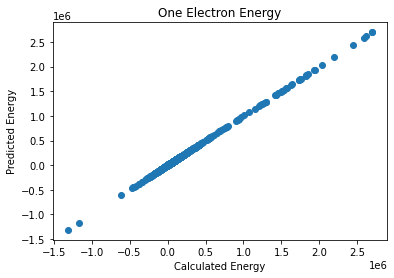

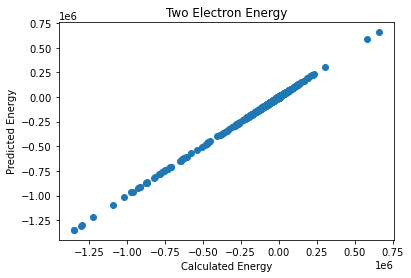

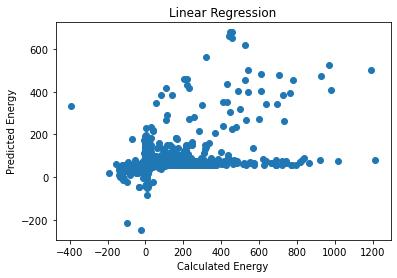

    4.1541    56.1808 172.46
   58.1191    55.3522   4.88
    4.3145    58.8741 172.69
  105.5189    52.9388  66.36
    5.5392    53.7473 162.63
   -8.2744    47.1284 285.19
   25.5121    42.1472  49.17
   30.3548    49.3256  47.62
   63.9076    54.3776  16.11
   83.4313    55.7268  39.82
   41.4216    57.2378  32.06
   22.1734    51.8878  80.24
   24.2986    54.9577  77.37
   31.5317    53.6698  51.97
   38.9583    55.6867  35.35
   22.1560    50.6874  78.34
    4.0272    31.0047 154.02
    4.4597    26.0345 141.50
    6.8991    -3.4921 609.99
   21.0769    58.8391  94.50
  -16.6918    35.2059 560.63
  -14.2981    35.8840 464.95
   -5.7736    36.9118 274.17
   -9.3377    36.7768 336.12
  -10.1578    37.3221 349.57
   -6.6443    37.8545 285.16
  -15.8984    34.4898 542.06
  -18.1346    35.2338 624.22
  -10.5579    36.3914 363.48
    3.1001    25.8901 157.23
    0.7075    19.7922 186.20
    7.2541    24.9666 109.94
   12.8639    25.0911  64.43
    6.5408    19.9755 101.33
    7.9860    

In [6]:
# test two linear models to predict energudiff
# LinearRegression
import sklearn.linear_model as lm
linearNR_Two = lm.LinearRegression()
linearNR_Two.fit(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1), \
                  df["PBE_Two_Electron_Energy"])
print(linearNR_Two.coef_, linearNR_Two.intercept_)
linearNR_One = lm.LinearRegression()
linearNR_One.fit(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1), \
                 df["PBE_One_Electron_Energy"])
print(linearNR_One.coef_, linearNR_One.intercept_)

Onepred = linearNR_One.predict(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1))
Twopred = linearNR_Two.predict(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1))

# scatter plot
plt.clf()
plt.scatter(df["PBE_One_Electron_Energy"], Onepred)
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('One Electron Energy')
plt.show()

plt.clf()
plt.scatter(df["PBE_Two_Electron_Energy"], Twopred)
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('Two Electron Energy')
plt.show()

predEnergy = Onepred + Twopred + \
    df["PBE_Nuclear_Repulsion"].values
calculatedEnergy = df["PBE_Nuclear_Repulsion"].values + \
    df["PBE_One_Electron_Energy"].values + \
    df["PBE_Two_Electron_Energy"].values

# scatter plot
plt.clf()
plt.scatter(calculatedEnergy, predEnergy)    
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('Linear Regression')
plt.show()

for i, ce in enumerate(calculatedEnergy):
    diff = abs(ce - predEnergy[i])/((ce+predEnergy[i])/2.0)
    print("%10.4f %10.4f %6.2f"%(ce, predEnergy[i], diff*100))

# PLSRegression using both one and two electron ?


In [7]:
featurestorms = set()
for tc in top_correlation:
    if tc not in featurestorms:
        for correlated in top_correlation[tc]:
            featurestorms.add(correlated[0])

print ("Features that are correlated with others and to remove")  
for idx, k in enumerate(featurestorms):
    print(idx+1 , " ", k)

Features that are correlated with others and to remove
1   TPSSh_Dispersion_correction
2   ZORA_E(X)
3   ZORA_Potential_Energy
4   PBE0_Potential_Energy
5   PBE_Two_Electron_Energy
6   ZORA_One_Electron_Energy
7   ZORA_Two_Electron_Energy
8   PBE0_FINAL_SINGLE_POINT_ENERGY
9   ZORA_E(C)
10   PBE0_Two_Electron_Energy
11   PBE0_Dispersion_correction
12   TPSSh_Potential_Energy
13   TPSSh_Nuclear_Repulsion
14   TPSSh_E(C)
15   PBE_One_Electron_Energy
16   TPSSh_FINAL_SINGLE_POINT_ENERGY
17   TPSSh_One_Electron_Energy
18   ZORA_Nuclear_Repulsion
19   PBE0_Kinetic_Energy
20   PBE0_Nuclear_Repulsion
21   PBE0_E(C)
22   ZORA_Dispersion_correction
23   TPSSh_Kinetic_Energy
24   TPSSh_Two_Electron_Energy
25   PBE0_E(X)
26   TPSSh_E(X)
27   ZORA_FINAL_SINGLE_POINT_ENERGY
28   ZORA_Kinetic_Energy
29   PBE0_One_Electron_Energy


In [8]:
print ("Features TO USE")
idx = 1
for f in allfeatures:
    if f not in featurestorms:
        print(idx, f) 
        idx += 1 

Features TO USE
1 PBE_FINAL_SINGLE_POINT_ENERGY
2 PBE_Kinetic_Energy
3 PBE_E(C)
4 PBE_Potential_Energy
5 PBE_Nuclear_Repulsion
6 PBE_Dispersion_correction
7 PBE_E(X)


In [9]:
featurestorm = list(featurestorms)

for setname in fullsetnames:
    commonutils.remove_features_fromset(allvalues_perset[setname], \
                                            list(featurestorm), \
                                            methods)

for setname in fullsetnames:
    models_results[setname].fulldescriptors = []
    models_results[setname].labels = []
    for idx, val in enumerate(allvalues_perset[setname]):
        models_results[setname].fulldescriptors.append({})
        for method in methods:
            if method+"_energydiff" in val:
                models_results[setname].fulldescriptors[idx].update(\
                    val[method+"_energydiff"])

        models_results[setname].labels.append(val["label"])

setname = "Full"
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                 models_results[setname].labels)

df = pd.DataFrame(X, columns=features_names)

Correlation matrix


<AxesSubplot:>

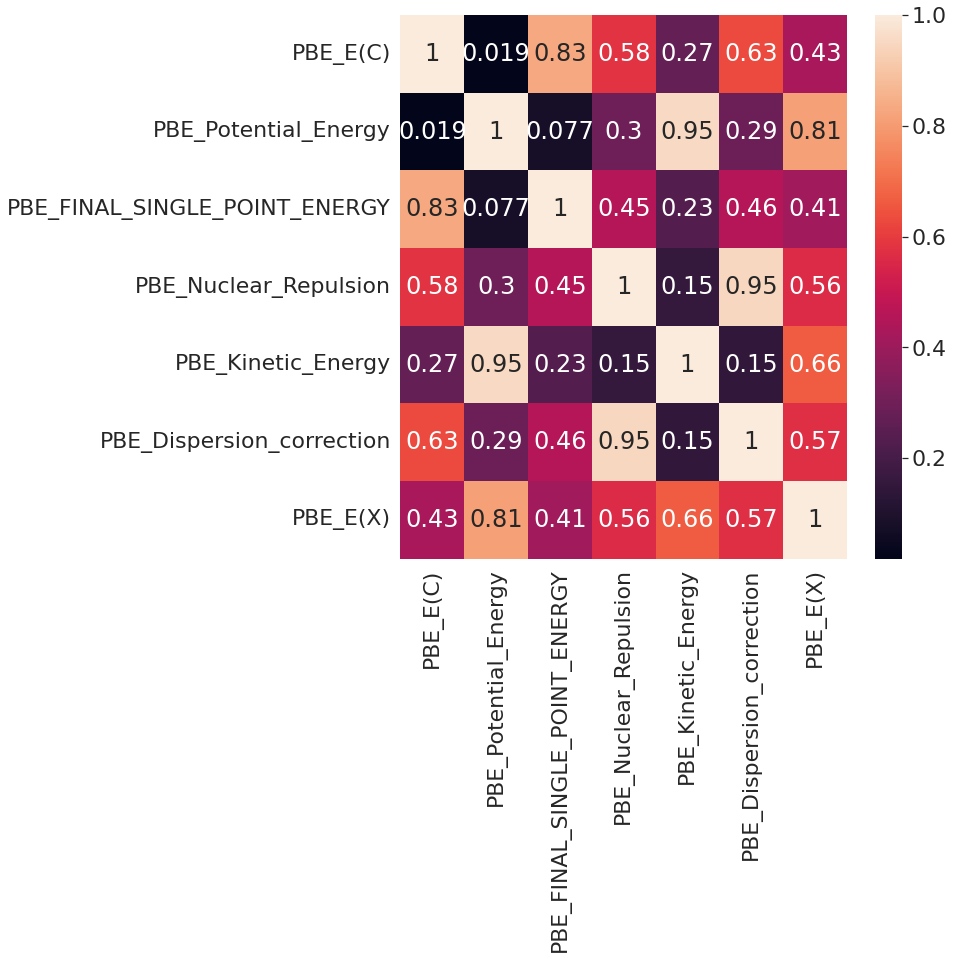

In [10]:
import seaborn as sns
%matplotlib inline
print("Correlation matrix")
plt.rcParams['figure.figsize'] = 10,10
sns.set(font_scale=2)
sns.heatmap(df.corr().abs(), annot=True)
#print(df.corr().abs())
#sns.heatmap(df, annot=True)

In [11]:
# search for the best model a simple grid search
nepochs = [50, 100]

batch_sizes = [4, 8, 16, 32]
#modelshapes = [[4, 4], [8, 8], [16, 16], \
#                [32, 32], [64, 64], [128, 128], \
#                [4, 4, 4], [8, 8, 8], [16, 16, 16], \
#                [32, 32, 32], [64, 64, 64], \
#                [128, 128, 128], [4, 4, 4, 4], \
#                [8, 8, 8, 8], [16, 16, 16, 16], \
#                [32, 32, 32, 32], [64, 64, 64, 64], \
#                [128, 128, 128, 128]]
modelshapes = [[4, 4, 4], [8, 8, 8], [16, 16, 16], \
                [32, 32, 32], [64, 64, 64], \
                [128, 128, 128], [4, 4, 4, 4], \
                [8, 8, 8, 8], [16, 16, 16, 16], \
                [32, 32, 32, 32], [64, 64, 64, 64], \
                [128, 128, 128, 128], [4, 4, 4, 4, 4], \
                [8, 8, 8, 8, 8], [16, 16, 16, 16, 16], 
                [32, 32, 32, 32, 32], [64, 64, 64, 64, 64],
                [128, 128, 128, 128, 128], [4, 4, 4, 4, 4, 4], \
                [8, 8, 8, 8, 8, 8], [16, 16, 16, 16, 16, 16], 
                [32, 32, 32, 32, 32, 32], [64, 64, 64, 64, 64, 64],
                [128, 128, 128, 128, 128, 128]]
setname = "Full"
X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
scalerx = preprocessing.StandardScaler().fit(X)
X_s = scalerx.transform(X) 
scalery = preprocessing.StandardScaler().fit(Y.reshape(-1, 1))
Y_s = scalery.transform(Y.reshape(-1, 1))
modelminrmse, modelsmaxr2 = \
        models.nn_model(0.2, X_s, Y_s, \
                    nepochs, modelshapes, batch_sizes, inputshape=-1,\
                    search=True)
    
print("Best NN model for set: ", setname, file=sys.stderr)
print("  RMSE: ", modelminrmse, file=sys.stderr)
print("    R2: ", modelsmaxr2, file=sys.stderr)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


Best NN model for set:  Full
  RMSE:  ([16, 16, 16, 16, 16], 100, 16)
    R2:  ([16, 16, 16, 16, 16], 100, 16)


In [12]:
import importlib
importlib.reload(models)

#build the final model and print the results
results = models.nn_model(0.2, X_s, Y_s, \
                    [modelminrmse[1]], \
                    [modelminrmse[0]], \
                    [modelminrmse[2]], \
                    inputshape=-1,\
                    search=False)

38/38 [==============================] - 0s 323us/step


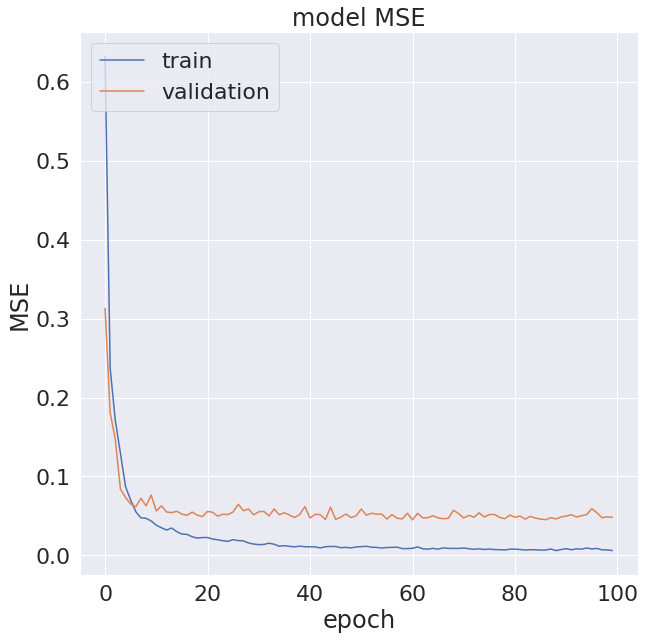

In [13]:
# summarize history for accuracy
history = results['history']
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
# summarize results
print("RMSE Train     : %5.2f"%results['rmse_train'])
print("RMSE Validation: %5.2f"%results['rmse_valid'])
print("RMSE Test      : %5.2f"%results['rmse_test'])
print("RMSE Full      : %5.2f"%results['rmse_full'])
print("R2 Train       : %5.2f"%results['r2_train'])
print("R2 Validation  : %5.2f"%results['r2_valid'])
print("R2 Test        : %5.2f"%results['r2_test'])
print("R2 Full        : %5.2f"%results['r2_full'])

RMSE Train     :  0.08
RMSE Validation:  0.22
RMSE Test      :  0.14
RMSE Full      :  0.13
R2 Train       :  0.99
R2 Validation  :  0.94
R2 Test        :  0.98
R2 Full        :  0.98


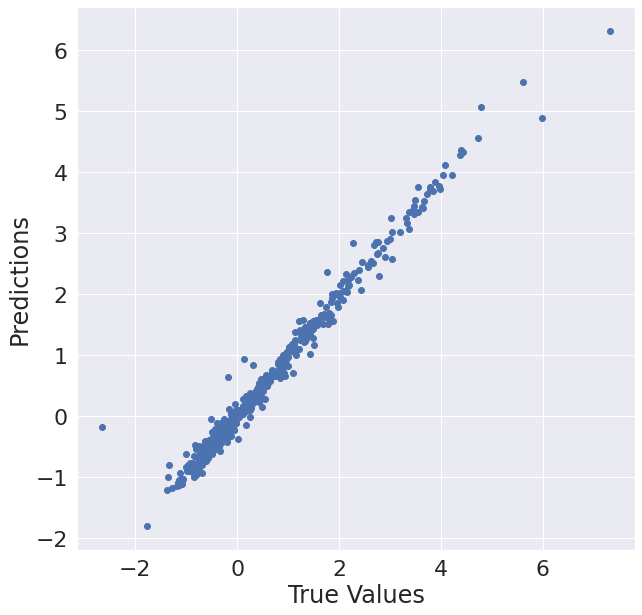

RMSE Full      : 21.01
R2 Full        :  0.98


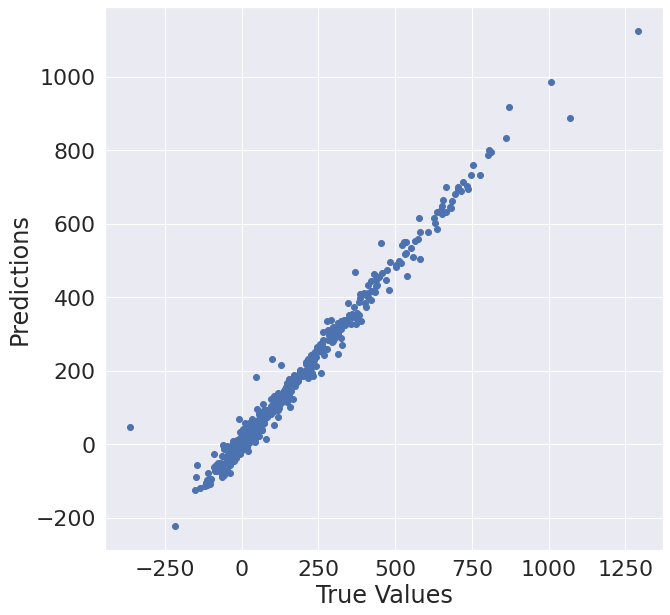

In [15]:
#denomrlize the results
plt.clf()
plt.scatter(results['y_full'], \
            results['y_pred_full'])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()
y_pred_full = scalery.inverse_transform(results['y_pred_full'])
y_full = scalery.inverse_transform(results['y_full'])
rmse_full = mean_squared_error(y_full, y_pred_full, squared=False)
r2_full = r2_score(y_full, y_pred_full)
print("RMSE Full      : %5.2f"%rmse_full)
print("R2 Full        : %5.2f"%r2_full)

# plot the results
plt.clf()
plt.scatter(y_full, y_pred_full)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [16]:
print(" Dim , %40s"% "Dataset", " , ", \
      "Best inside method RMSE", " , ", \
      "Best our method RMSE", " , ", \
      "RMSE , R2")
for setname in fullsetnames:
    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    
    X_s = scalerx.transform(X)
    Y_s = scalery.transform(Y.reshape(-1, 1))
    y_pred = scalery.inverse_transform(results['model'].predict(X_s, verbose=0))
    models_results[setname].y_pred = y_pred
    rmse = mean_squared_error(Y, y_pred, squared=False)
    r2 = r2_score(Y, y_pred)

    print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse, " , ", \
        "%7.3f"%r2)


 Dim ,                                  Dataset  ,  Best inside method RMSE  ,  Best our method RMSE  ,  RMSE , R2
 118 ,                          BARRIER_HEIGHTS  ,    6.410  ,   21.488  ,    8.811  ,    0.825
  10 ,                  BARRIER_HEIGHTS_BHDIV10  ,    9.191  ,   14.651  ,   10.995  ,    0.805
  26 ,                   BARRIER_HEIGHTS_BHPERI  ,    4.407  ,   17.811  ,    5.752  ,    0.670
  27 ,                  BARRIER_HEIGHTS_BHROT27  ,    0.611  ,    2.686  ,    3.673  ,    0.474
  24 ,                    BARRIER_HEIGHTS_INV24  ,    2.658  ,    5.711  ,   11.323  ,    0.759
  13 ,                     BARRIER_HEIGHTS_PX13  ,   11.730  ,   49.956  ,   13.374  ,    0.108
  18 ,                   BARRIER_HEIGHTS_WCPT18  ,    8.999  ,   24.302  ,    8.578  ,    0.862
 147 ,              INTRAMOLECULAR_INTERACTIONS  ,    1.137  ,    5.268  ,    7.331  ,   -0.463
  15 ,        INTRAMOLECULAR_INTERACTIONS_ACONF  ,    0.090  ,    1.250  ,    1.199  ,    0.113
  17 ,        INTRAMO

RMSE  BARRIER_HEIGHTS  :   8.81
R2    BARRIER_HEIGHTS  :   0.83


<Figure size 720x720 with 0 Axes>

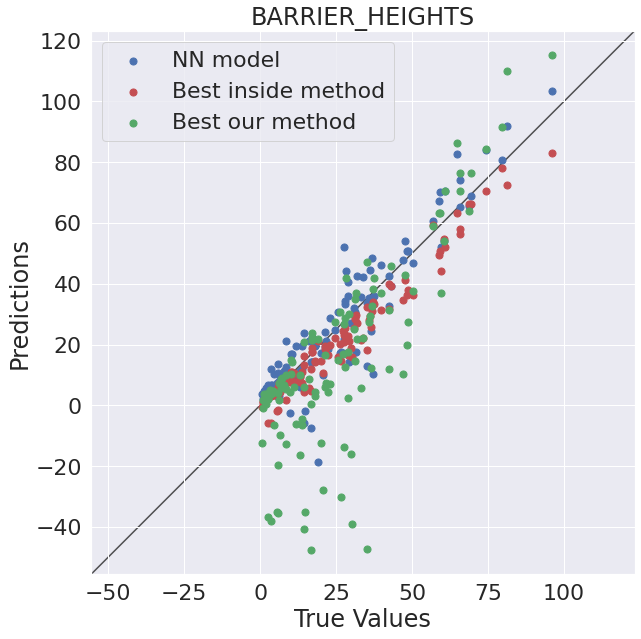

RMSE  BARRIER_HEIGHTS_BHDIV10  :  11.00
R2    BARRIER_HEIGHTS_BHDIV10  :   0.80


<Figure size 720x720 with 0 Axes>

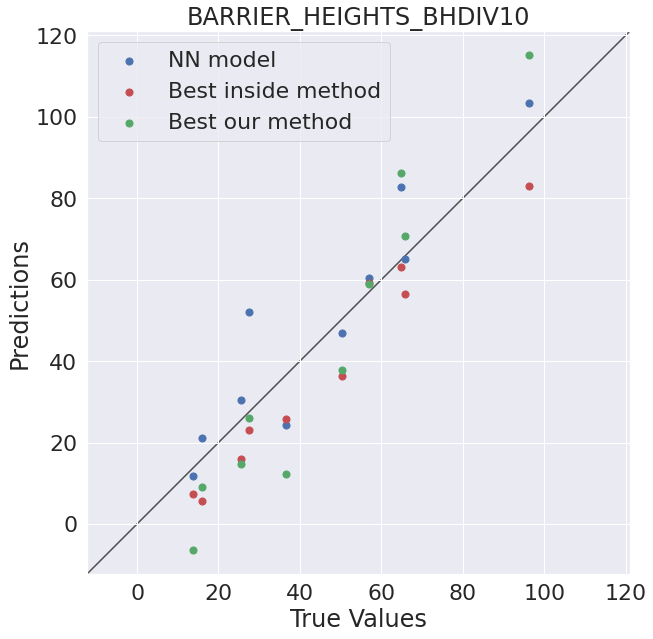

RMSE  BARRIER_HEIGHTS_BHPERI  :   5.75
R2    BARRIER_HEIGHTS_BHPERI  :   0.67


<Figure size 720x720 with 0 Axes>

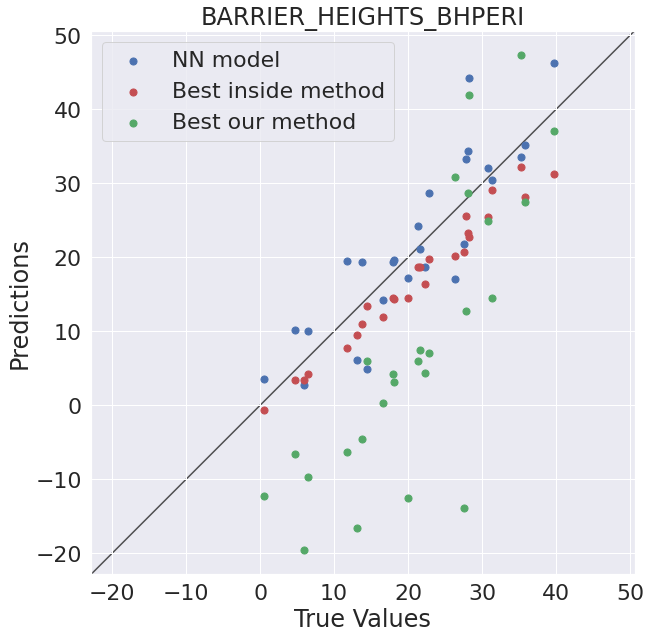

RMSE  BARRIER_HEIGHTS_BHROT27  :   3.67
R2    BARRIER_HEIGHTS_BHROT27  :   0.47


<Figure size 720x720 with 0 Axes>

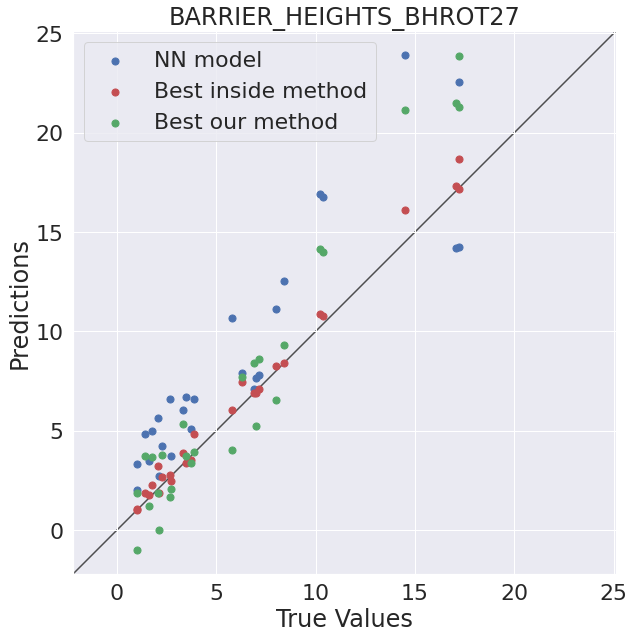

RMSE  BARRIER_HEIGHTS_INV24  :  11.32
R2    BARRIER_HEIGHTS_INV24  :   0.76


<Figure size 720x720 with 0 Axes>

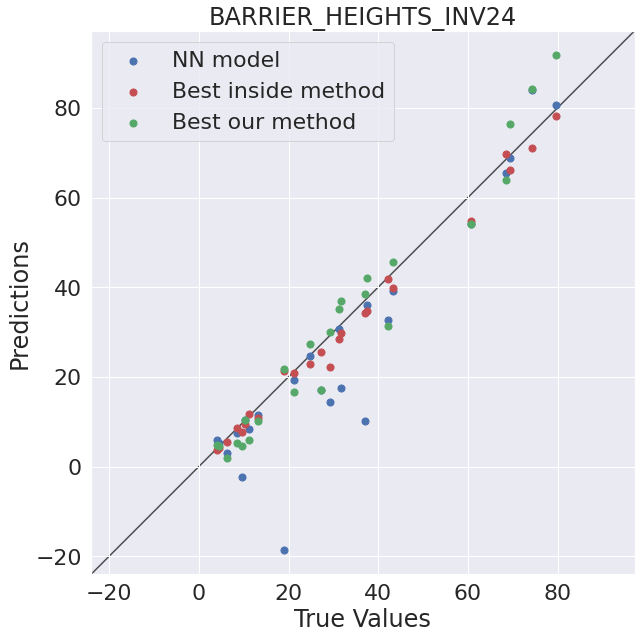

RMSE  BARRIER_HEIGHTS_PX13  :  13.37
R2    BARRIER_HEIGHTS_PX13  :   0.11


<Figure size 720x720 with 0 Axes>

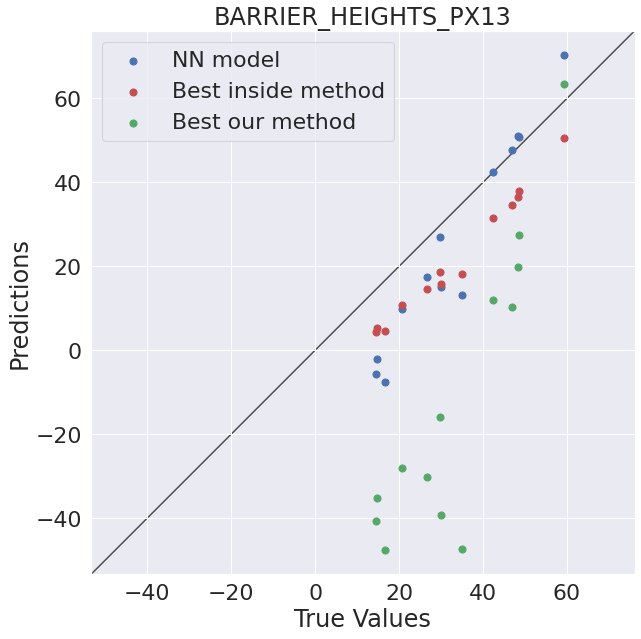

RMSE  BARRIER_HEIGHTS_WCPT18  :   8.58
R2    BARRIER_HEIGHTS_WCPT18  :   0.86


<Figure size 720x720 with 0 Axes>

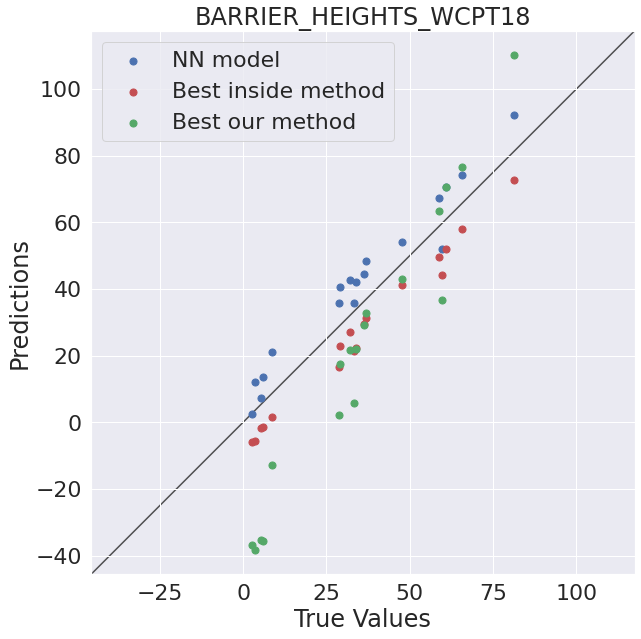

RMSE  INTRAMOLECULAR_INTERACTIONS  :   7.33
R2    INTRAMOLECULAR_INTERACTIONS  :  -0.46


<Figure size 720x720 with 0 Axes>

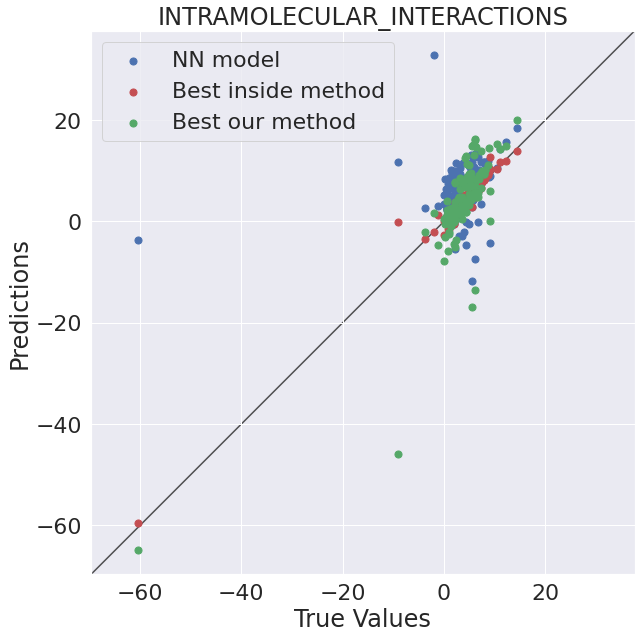

RMSE  INTRAMOLECULAR_INTERACTIONS_ACONF  :   1.20
R2    INTRAMOLECULAR_INTERACTIONS_ACONF  :   0.11


<Figure size 720x720 with 0 Axes>

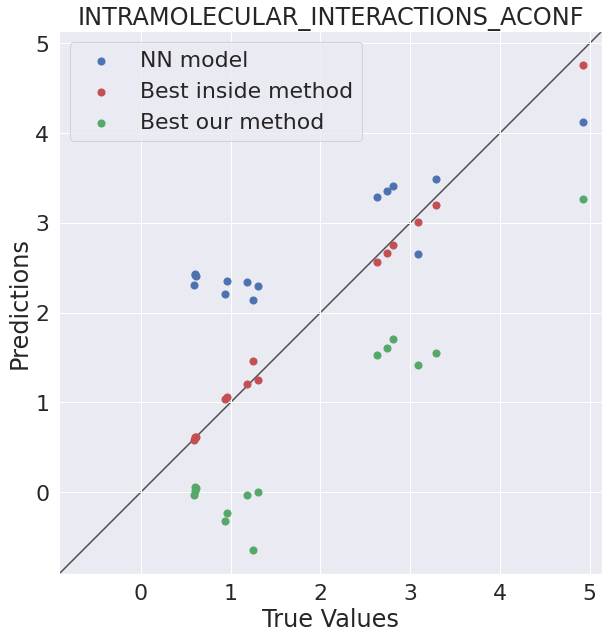

RMSE  INTRAMOLECULAR_INTERACTIONS_ICONF  :   5.00
R2    INTRAMOLECULAR_INTERACTIONS_ICONF  :  -1.51


<Figure size 720x720 with 0 Axes>

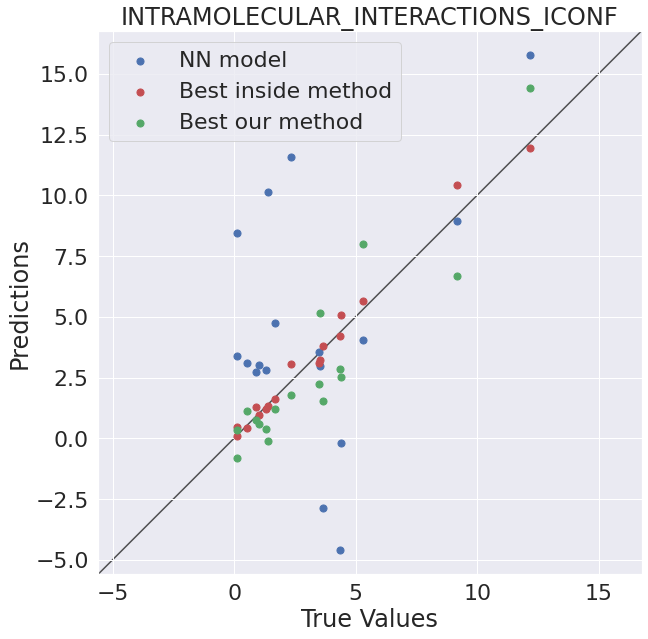

RMSE  INTRAMOLECULAR_INTERACTIONS_IDISP  :  29.11
R2    INTRAMOLECULAR_INTERACTIONS_IDISP  :  -0.66


<Figure size 720x720 with 0 Axes>

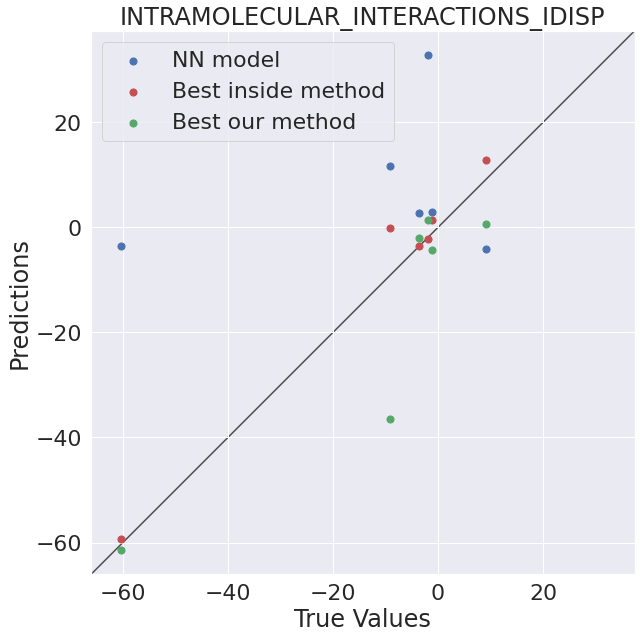

RMSE  INTRAMOLECULAR_INTERACTIONS_MCONF  :   4.46
R2    INTRAMOLECULAR_INTERACTIONS_MCONF  :  -4.02


<Figure size 720x720 with 0 Axes>

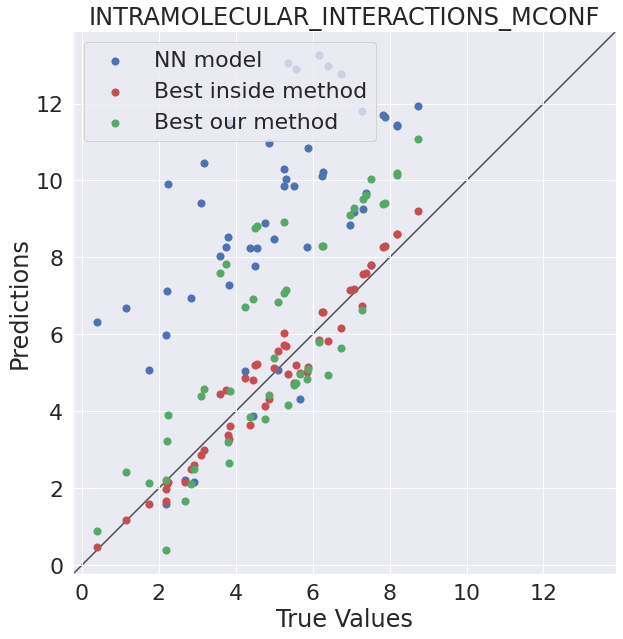

RMSE  INTRAMOLECULAR_INTERACTIONS_PCONF21  :   4.87
R2    INTRAMOLECULAR_INTERACTIONS_PCONF21  : -40.61


<Figure size 720x720 with 0 Axes>

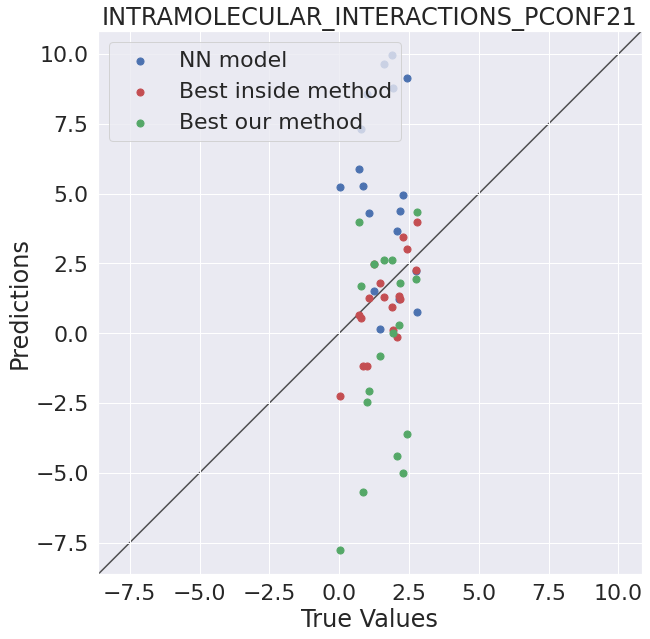

RMSE  INTRAMOLECULAR_INTERACTIONS_SCONF  :   5.72
R2    INTRAMOLECULAR_INTERACTIONS_SCONF  :  -8.40


<Figure size 720x720 with 0 Axes>

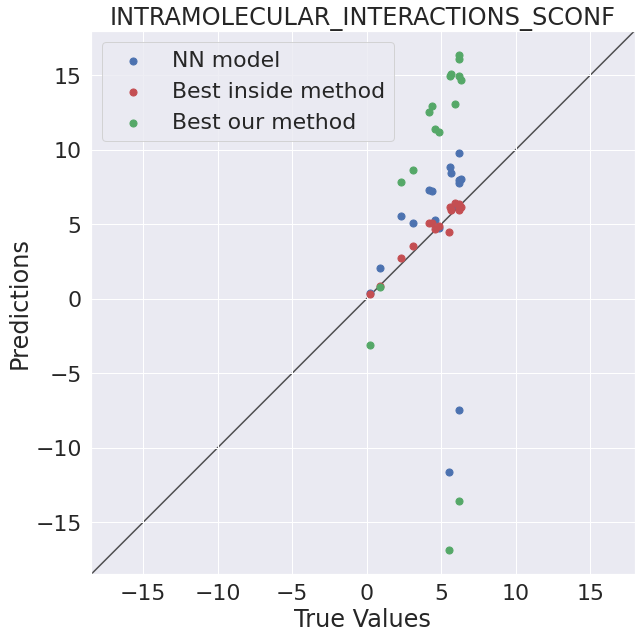

RMSE  INTRAMOLECULAR_INTERACTIONS_UPU23  :   4.02
R2    INTRAMOLECULAR_INTERACTIONS_UPU23  :  -0.67


<Figure size 720x720 with 0 Axes>

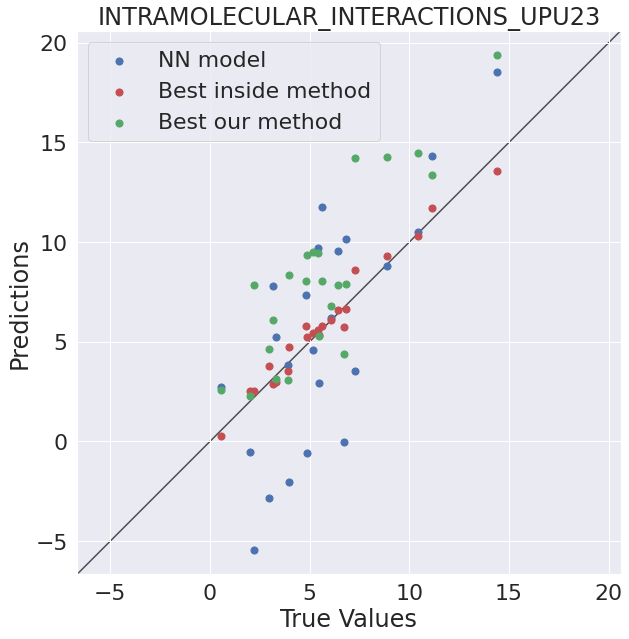

RMSE  SMALL_MOLECULES  :  18.83
R2    SMALL_MOLECULES  :   0.99


<Figure size 720x720 with 0 Axes>

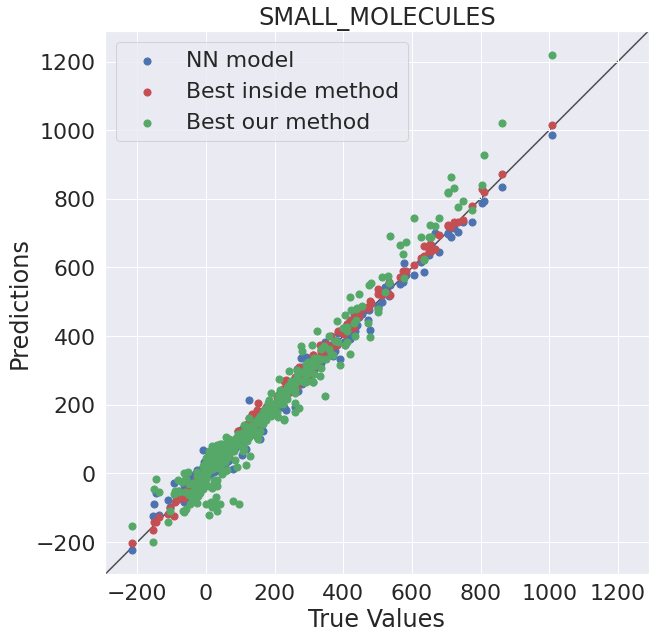

RMSE  SMALL_MOLECULES_AL2X6  :   7.90
R2    SMALL_MOLECULES_AL2X6  :   0.18


<Figure size 720x720 with 0 Axes>

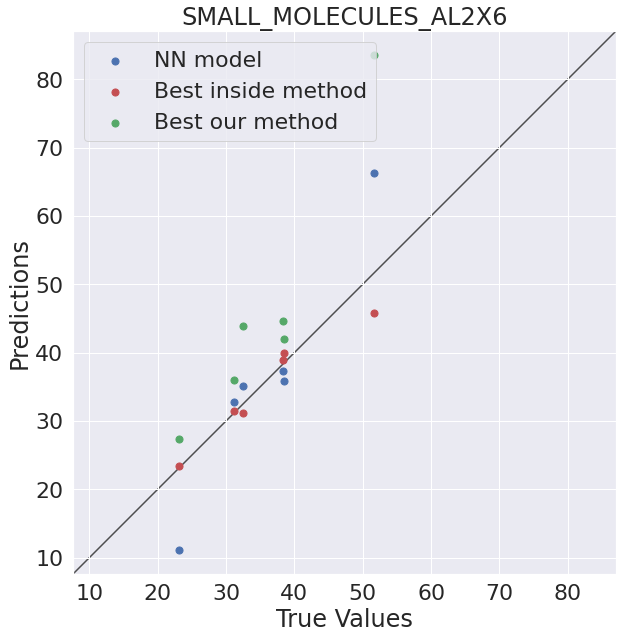

RMSE  SMALL_MOLECULES_ALK8  :  14.35
R2    SMALL_MOLECULES_ALK8  :   0.79


<Figure size 720x720 with 0 Axes>

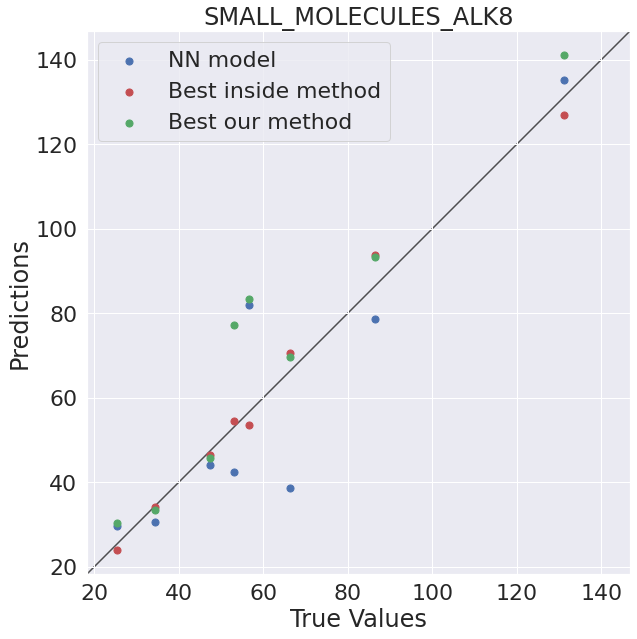

RMSE  SMALL_MOLECULES_ALKBDE10  :  19.23
R2    SMALL_MOLECULES_ALKBDE10  :   0.63


<Figure size 720x720 with 0 Axes>

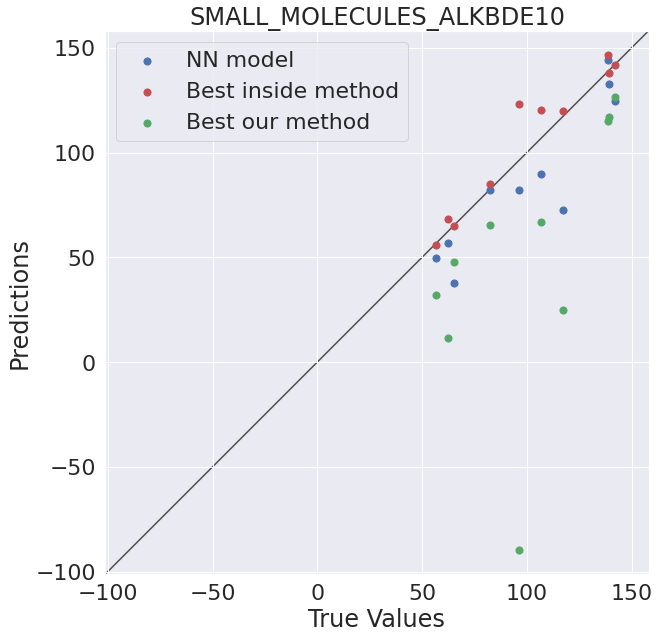

RMSE  SMALL_MOLECULES_DC13  :  31.39
R2    SMALL_MOLECULES_DC13  :   0.80


<Figure size 720x720 with 0 Axes>

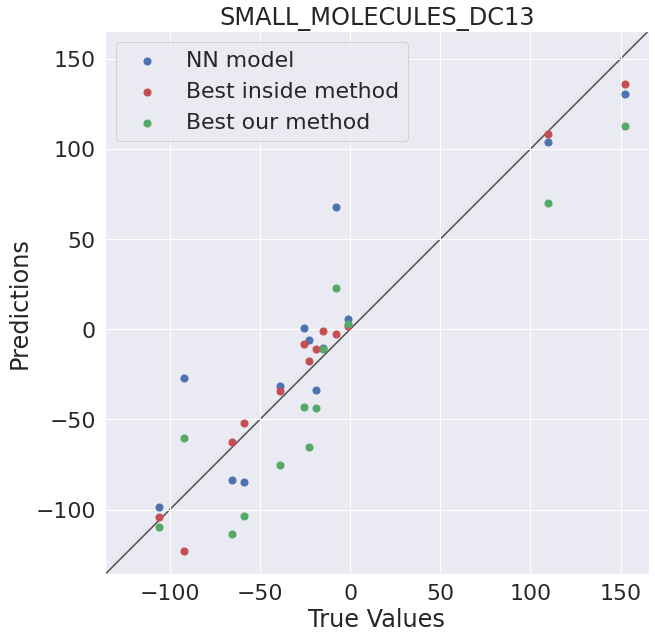

RMSE  SMALL_MOLECULES_DIPCS10  :  23.44
R2    SMALL_MOLECULES_DIPCS10  :   0.91


<Figure size 720x720 with 0 Axes>

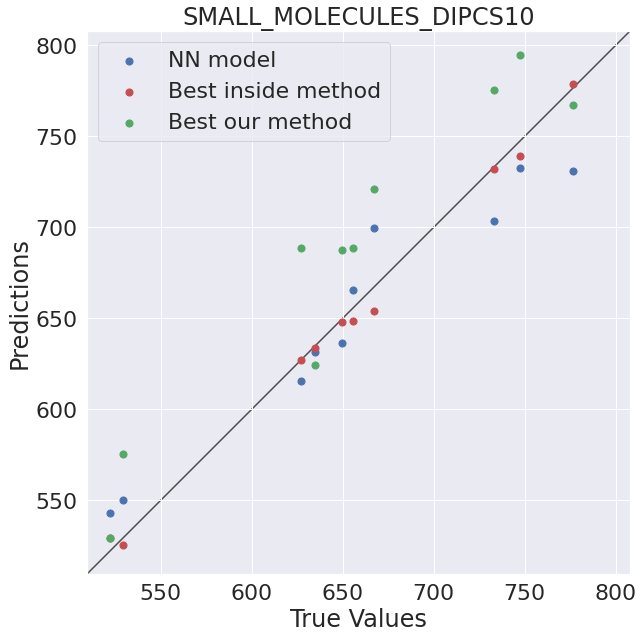

RMSE  SMALL_MOLECULES_FH51  :  21.49
R2    SMALL_MOLECULES_FH51  :   0.58


<Figure size 720x720 with 0 Axes>

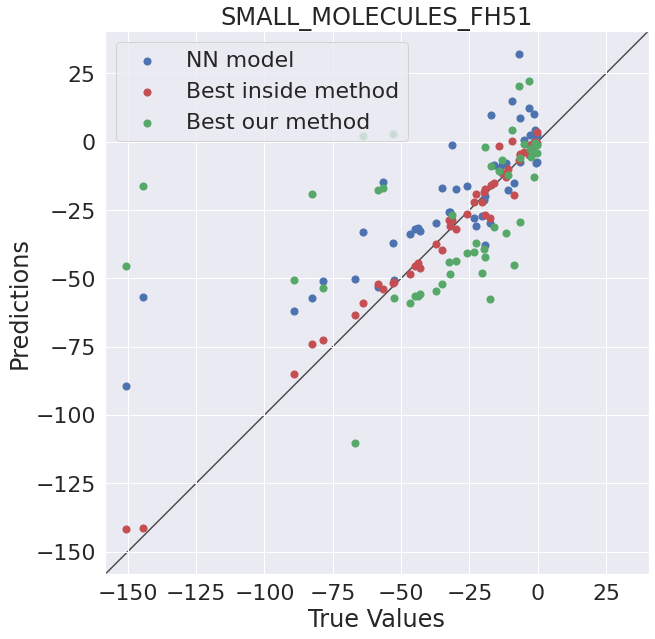

RMSE  SMALL_MOLECULES_G21EA  :  16.73
R2    SMALL_MOLECULES_G21EA  :   0.48


<Figure size 720x720 with 0 Axes>

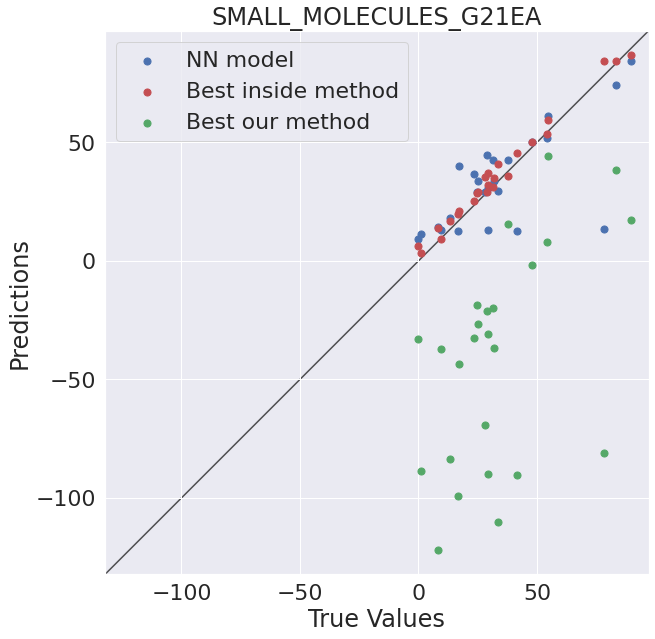

RMSE  SMALL_MOLECULES_G21IP  :  15.37
R2    SMALL_MOLECULES_G21IP  :   0.94


<Figure size 720x720 with 0 Axes>

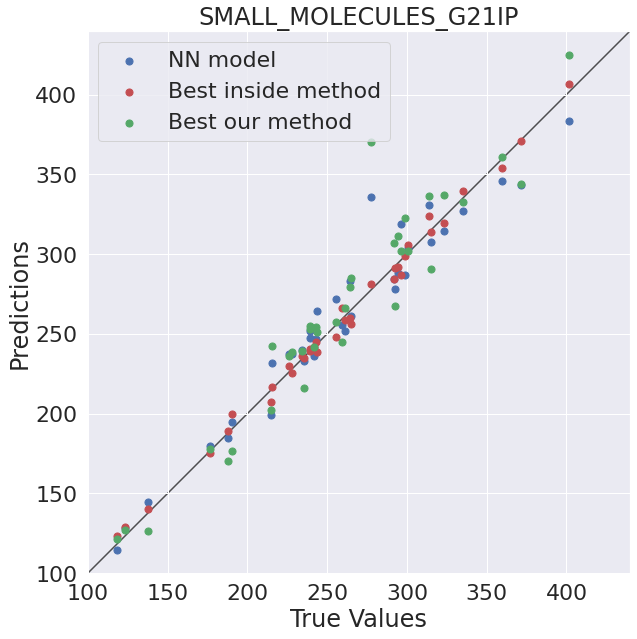

RMSE  SMALL_MOLECULES_G2RC  :  19.45
R2    SMALL_MOLECULES_G2RC  :   0.86


<Figure size 720x720 with 0 Axes>

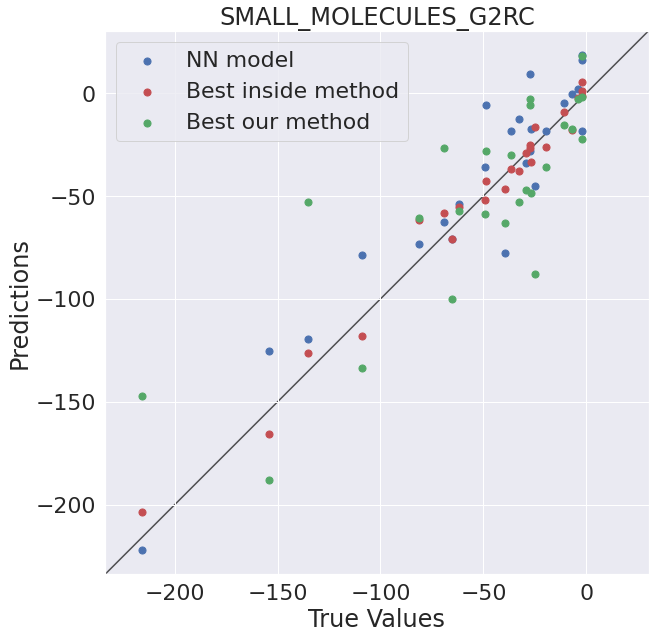

RMSE  SMALL_MOLECULES_NBPRC  :  14.10
R2    SMALL_MOLECULES_NBPRC  :   0.77


<Figure size 720x720 with 0 Axes>

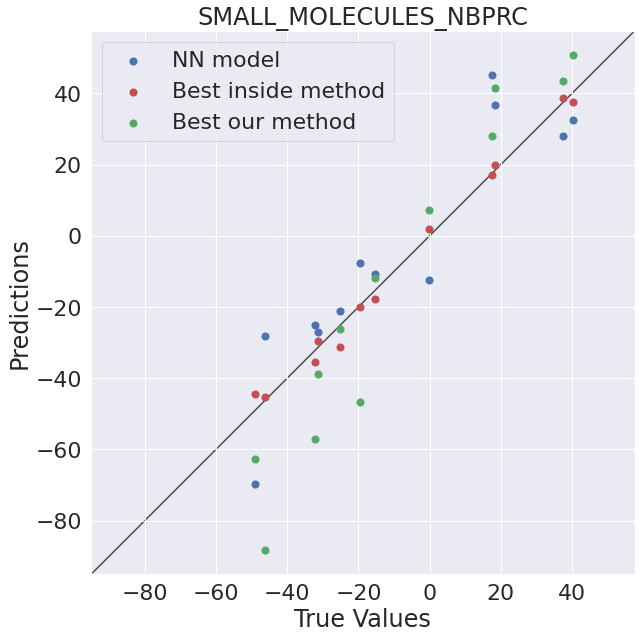

RMSE  SMALL_MOLECULES_PA26  :  20.21
R2    SMALL_MOLECULES_PA26  :   0.61


<Figure size 720x720 with 0 Axes>

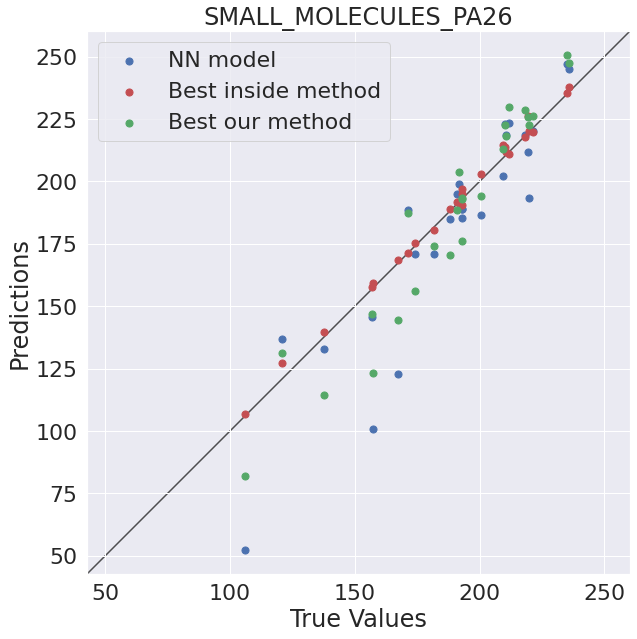

RMSE  SMALL_MOLECULES_RC21  :  24.14
R2    SMALL_MOLECULES_RC21  :   0.18


<Figure size 720x720 with 0 Axes>

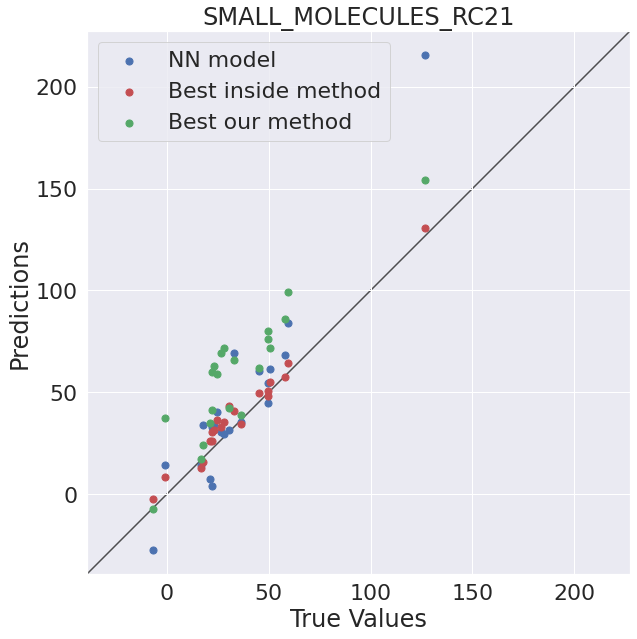

RMSE  SMALL_MOLECULES_SIE4x4  :  16.41
R2    SMALL_MOLECULES_SIE4x4  :   0.14


<Figure size 720x720 with 0 Axes>

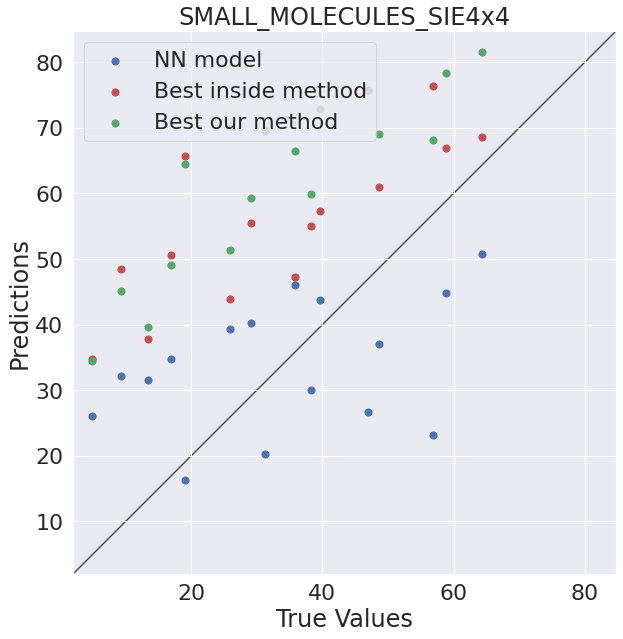

RMSE  SMALL_MOLECULES_TAUT15  :   7.23
R2    SMALL_MOLECULES_TAUT15  :  -2.28


<Figure size 720x720 with 0 Axes>

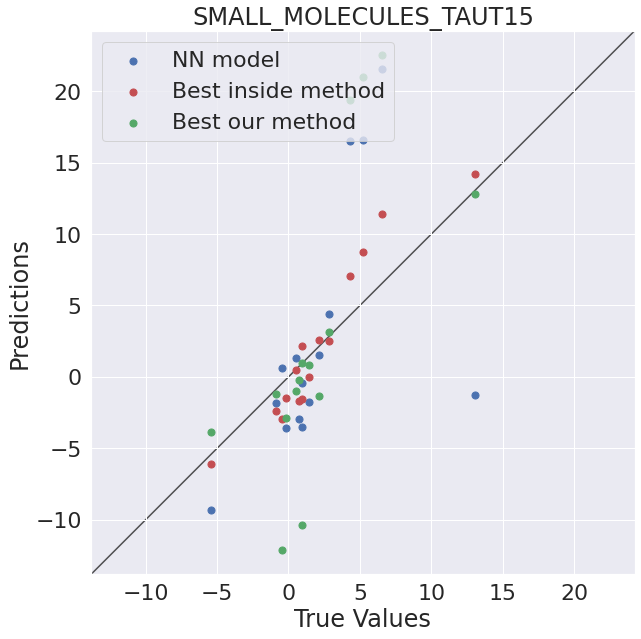

RMSE  SMALL_MOLECULES_W4-11  :  18.64
R2    SMALL_MOLECULES_W4-11  :   0.99


<Figure size 720x720 with 0 Axes>

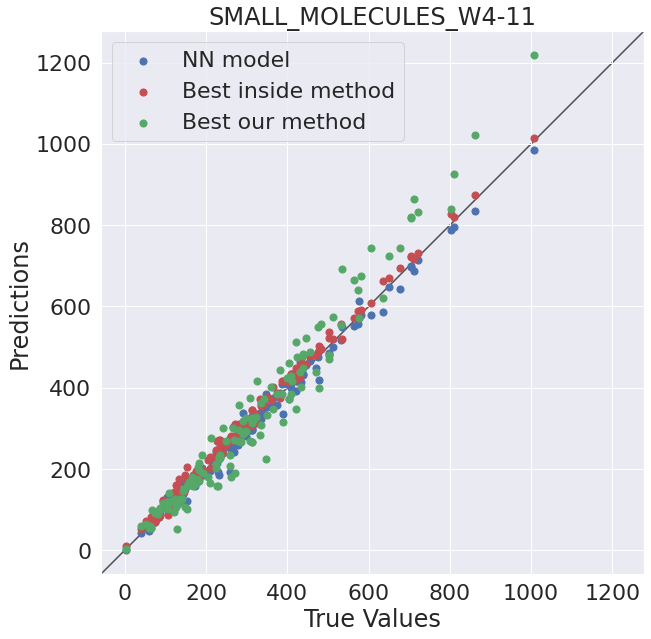

RMSE  SMALL_MOLECULES_YBDE18  :   9.76
R2    SMALL_MOLECULES_YBDE18  :   0.76


<Figure size 720x720 with 0 Axes>

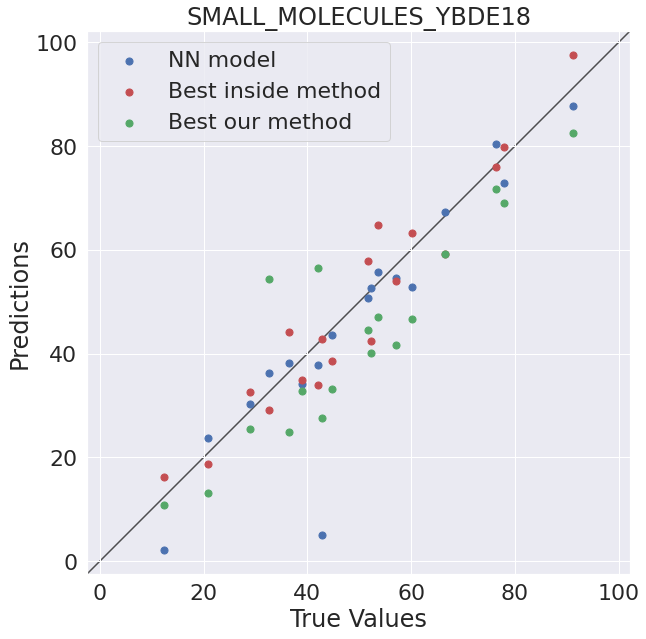

RMSE  INTERMOLECULAR_INTERACTIONS  :   8.40
R2    INTERMOLECULAR_INTERACTIONS  :   0.96


<Figure size 720x720 with 0 Axes>

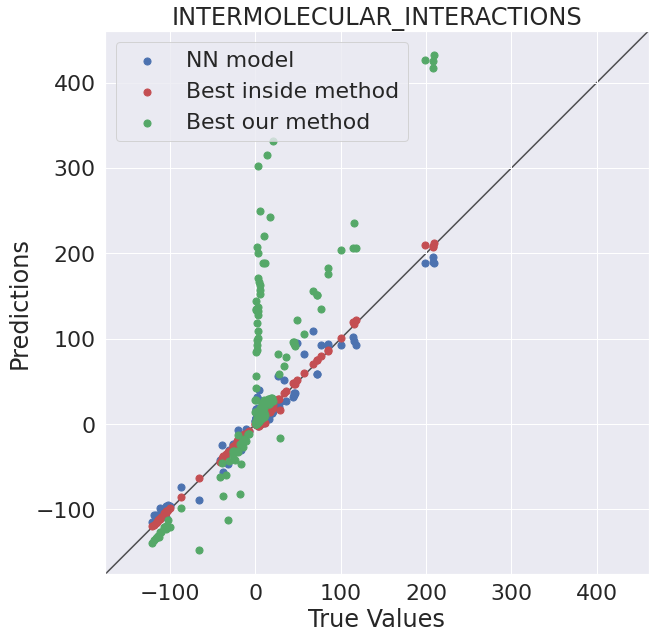

RMSE  INTERMOLECULAR_INTERACTIONS_ADIM6  :   3.35
R2    INTERMOLECULAR_INTERACTIONS_ADIM6  :  -4.30


<Figure size 720x720 with 0 Axes>

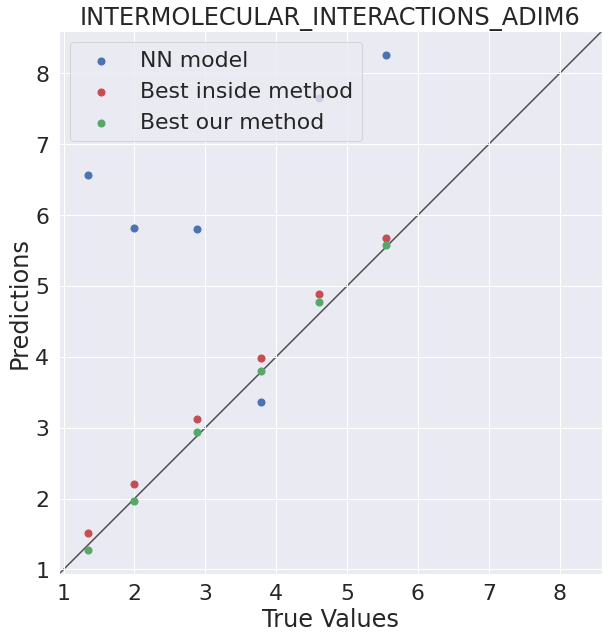

RMSE  INTERMOLECULAR_INTERACTIONS_AHB21  :   8.26
R2    INTERMOLECULAR_INTERACTIONS_AHB21  :   0.62


<Figure size 720x720 with 0 Axes>

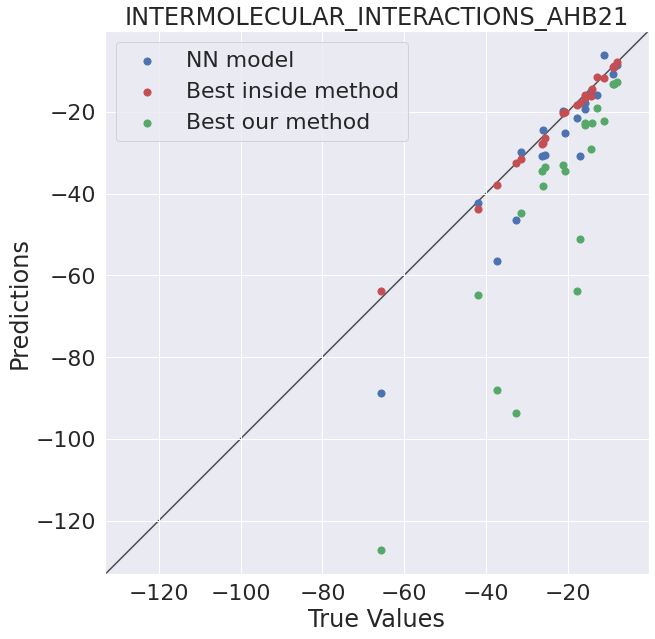

RMSE  INTERMOLECULAR_INTERACTIONS_CARBHB12  :   3.93
R2    INTERMOLECULAR_INTERACTIONS_CARBHB12  :   0.14


<Figure size 720x720 with 0 Axes>

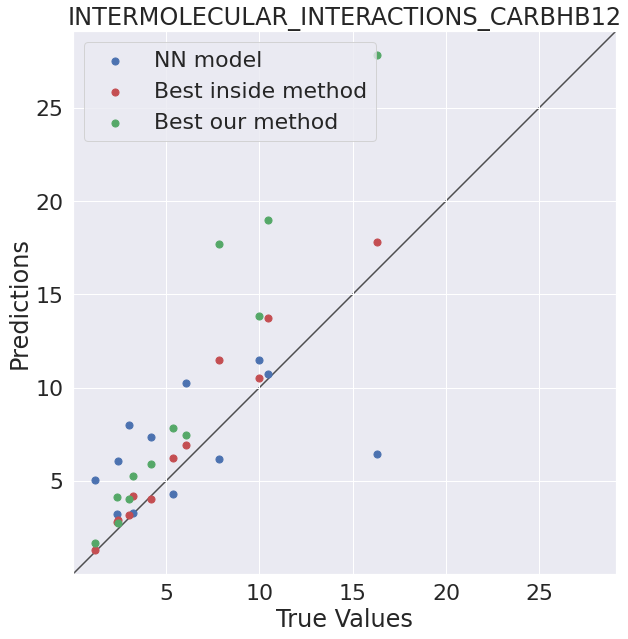

RMSE  INTERMOLECULAR_INTERACTIONS_CHB6  :   8.36
R2    INTERMOLECULAR_INTERACTIONS_CHB6  :  -0.21


<Figure size 720x720 with 0 Axes>

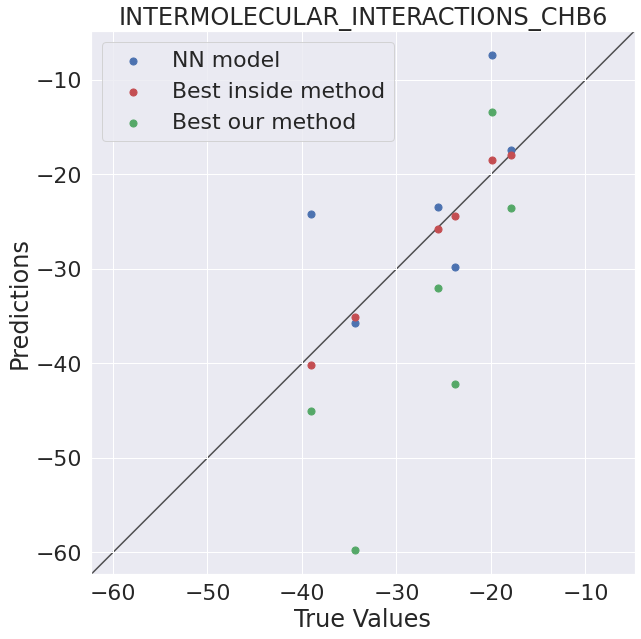

RMSE  INTERMOLECULAR_INTERACTIONS_HAL59  :   9.58
R2    INTERMOLECULAR_INTERACTIONS_HAL59  :  -4.17


<Figure size 720x720 with 0 Axes>

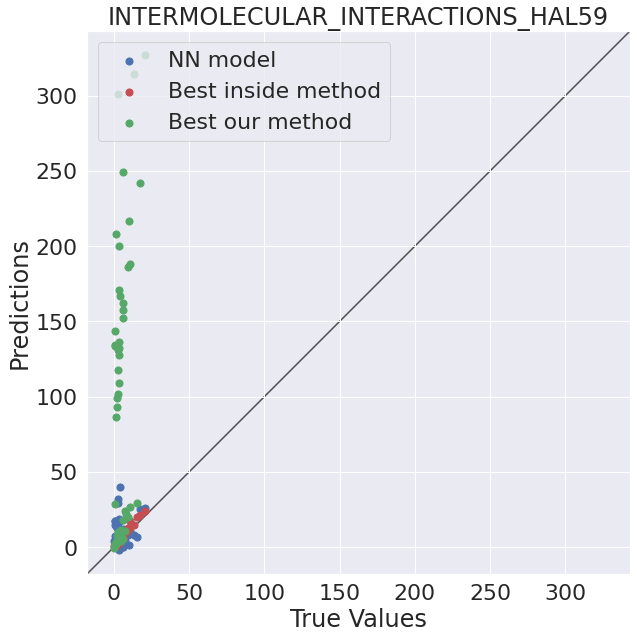

RMSE  INTERMOLECULAR_INTERACTIONS_IL16  :   8.11
R2    INTERMOLECULAR_INTERACTIONS_IL16  :  -0.01


<Figure size 720x720 with 0 Axes>

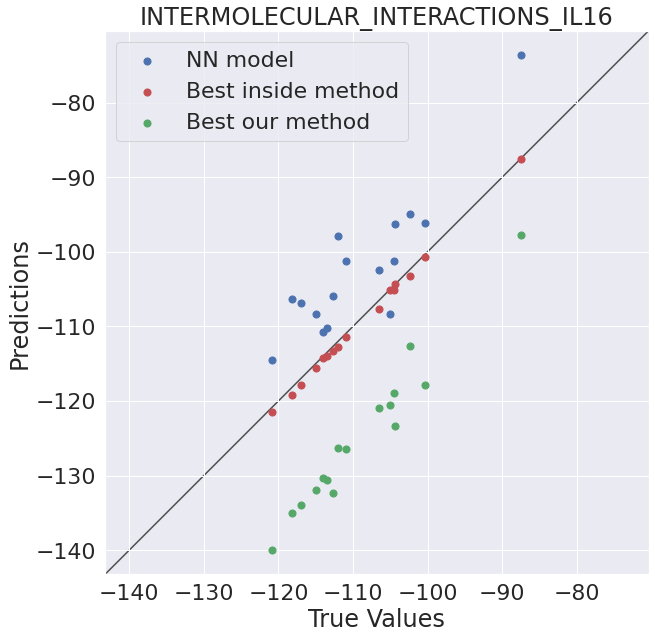

RMSE  INTERMOLECULAR_INTERACTIONS_PNICO23  :   3.80
R2    INTERMOLECULAR_INTERACTIONS_PNICO23  :  -1.07


<Figure size 720x720 with 0 Axes>

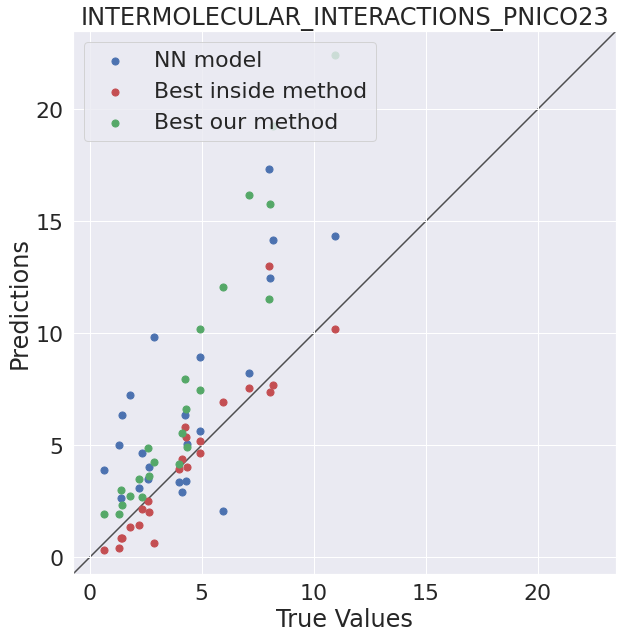

RMSE  INTERMOLECULAR_INTERACTIONS_RG18  :   4.35
R2    INTERMOLECULAR_INTERACTIONS_RG18  : -116.59


<Figure size 720x720 with 0 Axes>

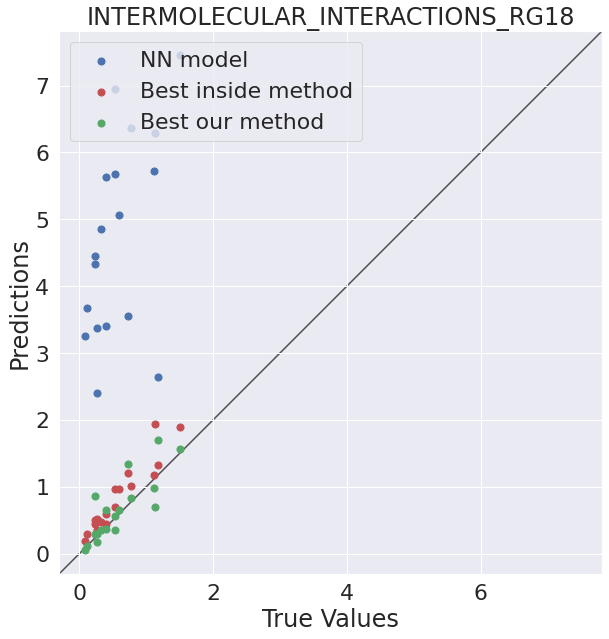

RMSE  INTERMOLECULAR_INTERACTIONS_S22  :   3.05
R2    INTERMOLECULAR_INTERACTIONS_S22  :   0.77


<Figure size 720x720 with 0 Axes>

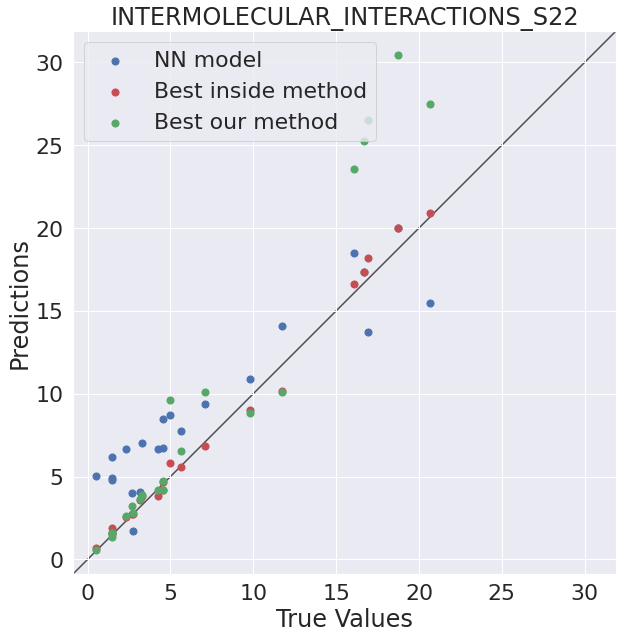

RMSE  INTERMOLECULAR_INTERACTIONS_S66  :   2.96
R2    INTERMOLECULAR_INTERACTIONS_S66  :   0.48


<Figure size 720x720 with 0 Axes>

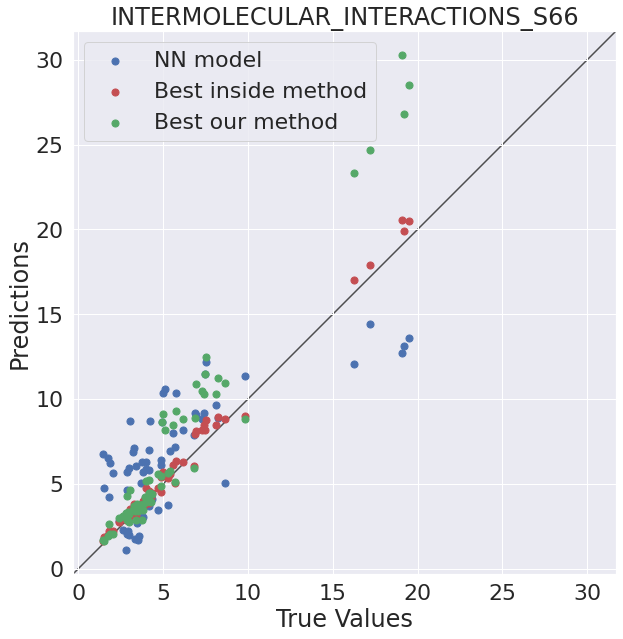

RMSE  INTERMOLECULAR_INTERACTIONS_WATER27  :  18.70
R2    INTERMOLECULAR_INTERACTIONS_WATER27  :   0.90


<Figure size 720x720 with 0 Axes>

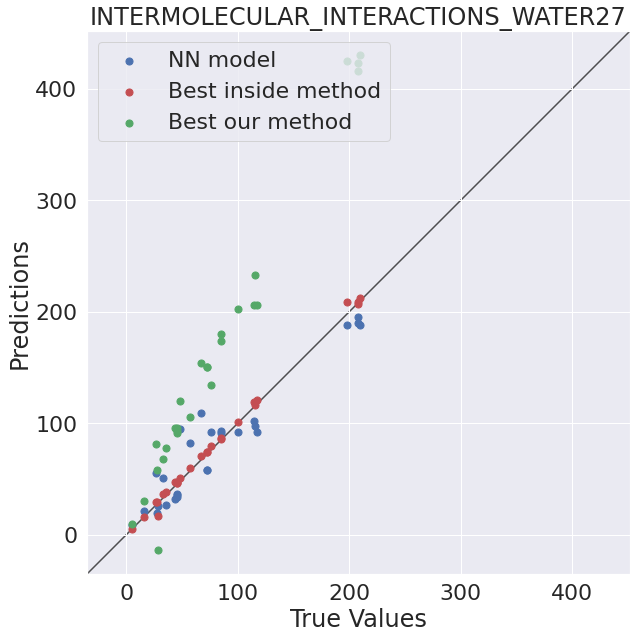

RMSE  LARGE_SYSTEMS  :  38.58
R2    LARGE_SYSTEMS  :   0.97


<Figure size 720x720 with 0 Axes>

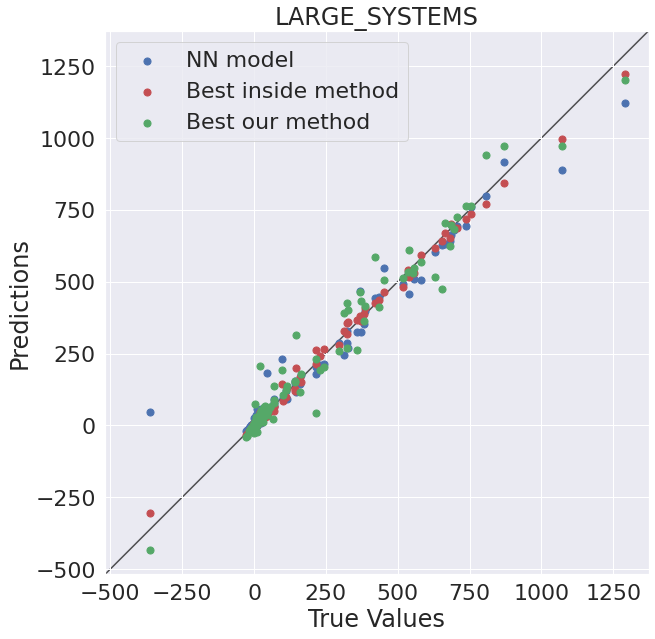

RMSE  LARGE_SYSTEMS_BSR36  :   3.68
R2    LARGE_SYSTEMS_BSR36  :   0.88


<Figure size 720x720 with 0 Axes>

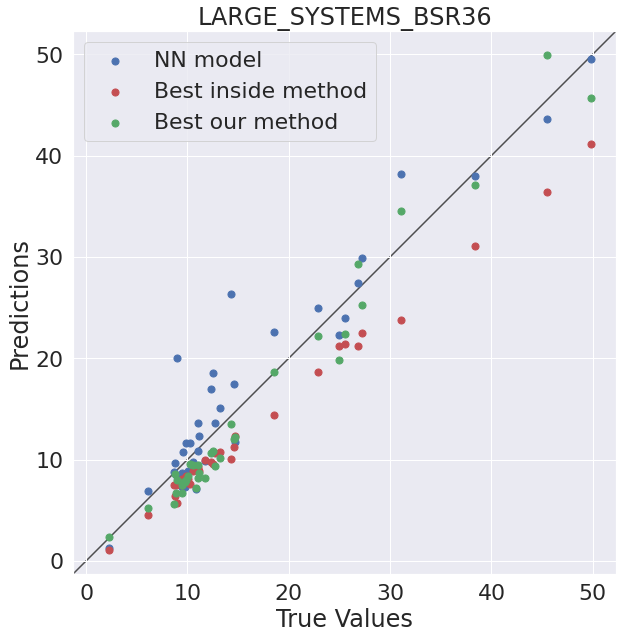

RMSE  LARGE_SYSTEMS_C60ISO  :   6.50
R2    LARGE_SYSTEMS_C60ISO  :   0.98


<Figure size 720x720 with 0 Axes>

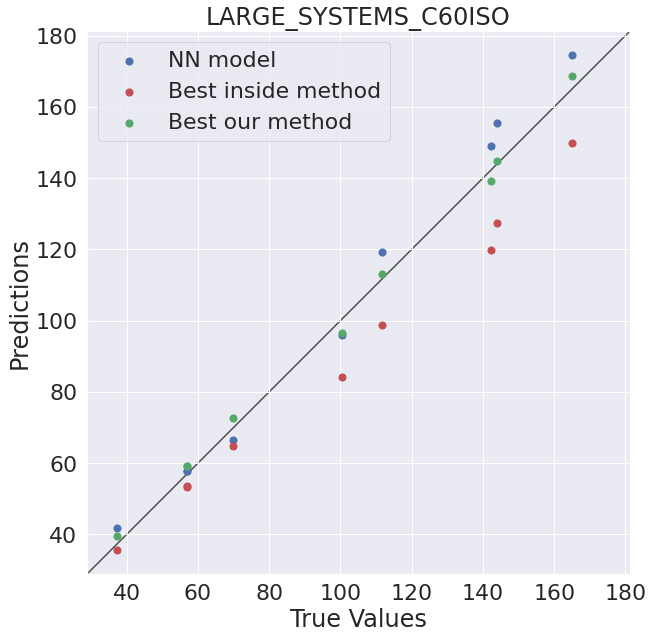

RMSE  LARGE_SYSTEMS_CDIE20  :   5.61
R2    LARGE_SYSTEMS_CDIE20  :  -1.34


<Figure size 720x720 with 0 Axes>

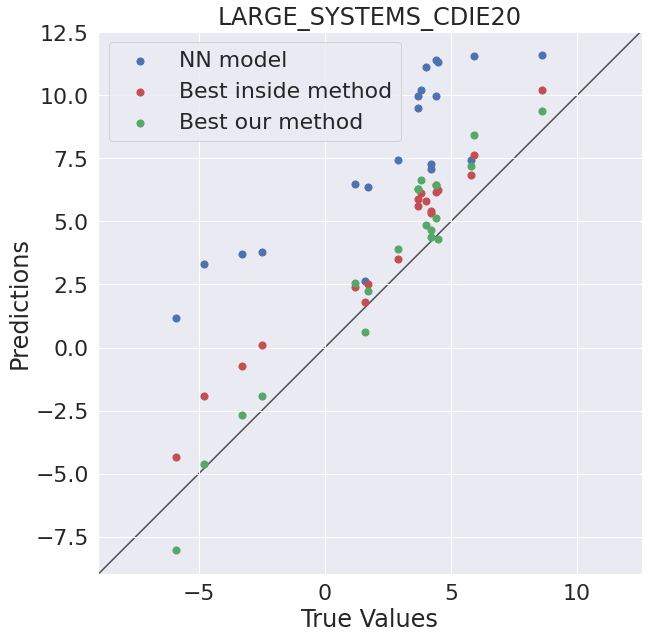

RMSE  LARGE_SYSTEMS_ISO34  :   7.02
R2    LARGE_SYSTEMS_ISO34  :   0.75


<Figure size 720x720 with 0 Axes>

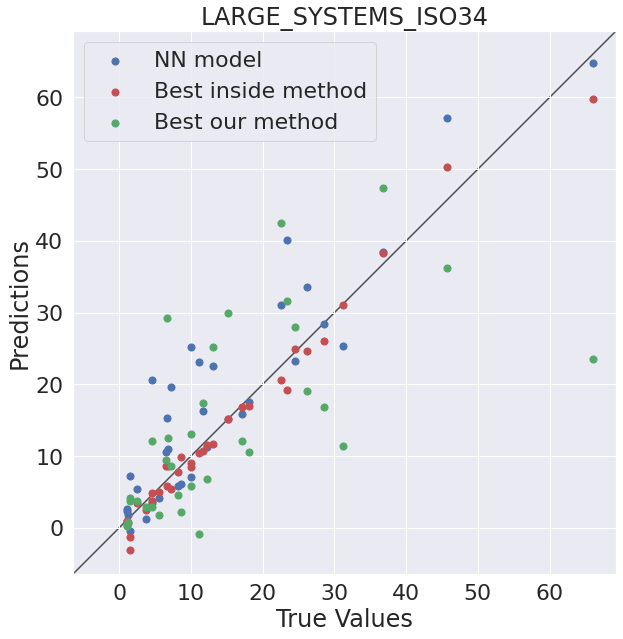

RMSE  LARGE_SYSTEMS_ISOL24  :  14.63
R2    LARGE_SYSTEMS_ISOL24  :   0.35


<Figure size 720x720 with 0 Axes>

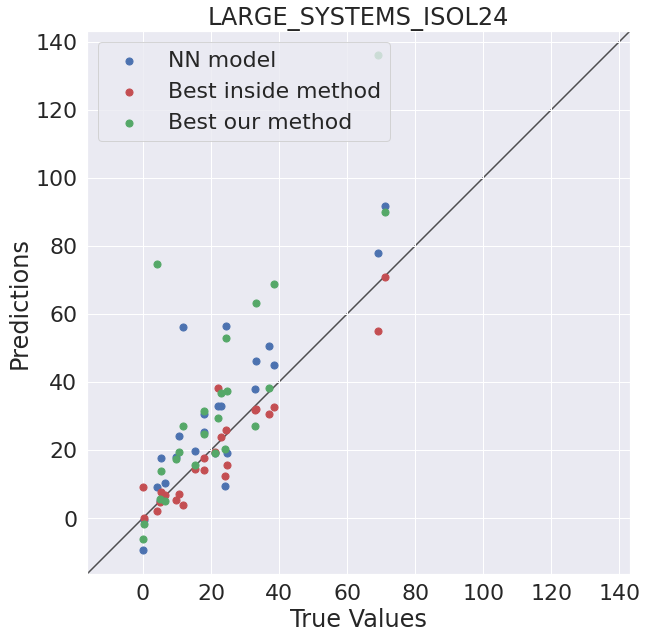

RMSE  LARGE_SYSTEMS_MB16-43  :  87.47
R2    LARGE_SYSTEMS_MB16-43  :   0.91


<Figure size 720x720 with 0 Axes>

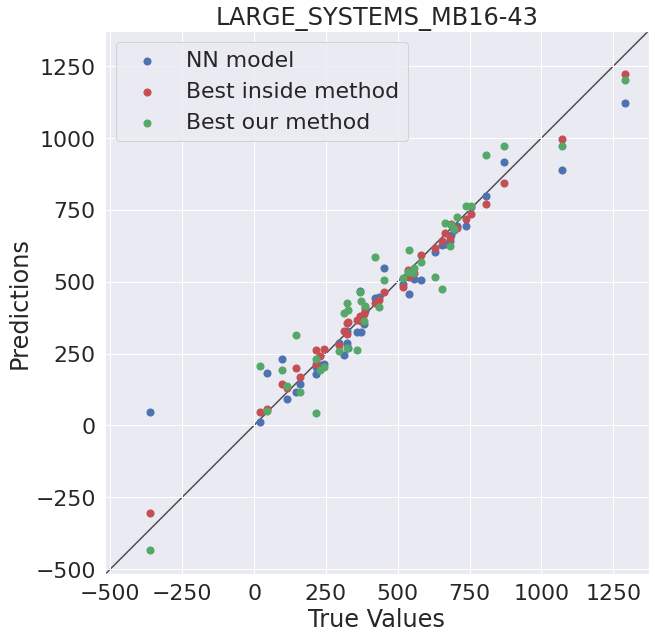

RMSE  LARGE_SYSTEMS_PArel  :  10.64
R2    LARGE_SYSTEMS_PArel  :  -5.50


<Figure size 720x720 with 0 Axes>

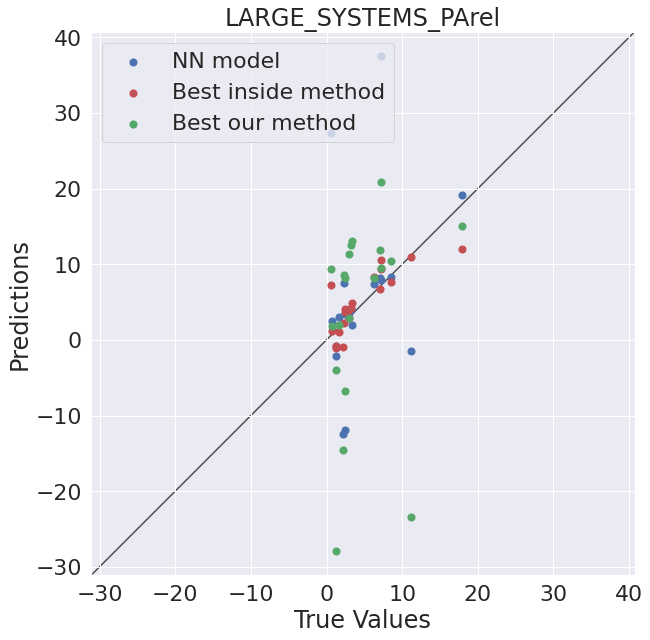

RMSE  LARGE_SYSTEMS_RSE43  :   5.44
R2    LARGE_SYSTEMS_RSE43  :   0.45


<Figure size 720x720 with 0 Axes>

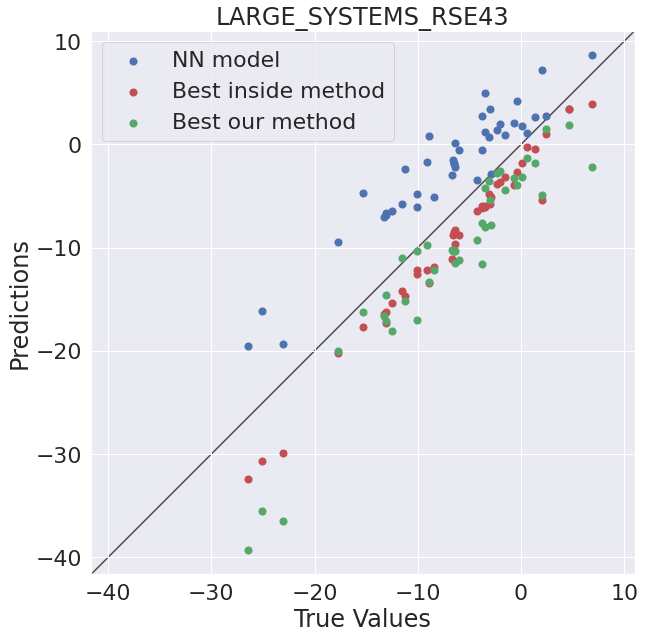

RMSE  Full  :  21.01
R2    Full  :   0.98


<Figure size 720x720 with 0 Axes>

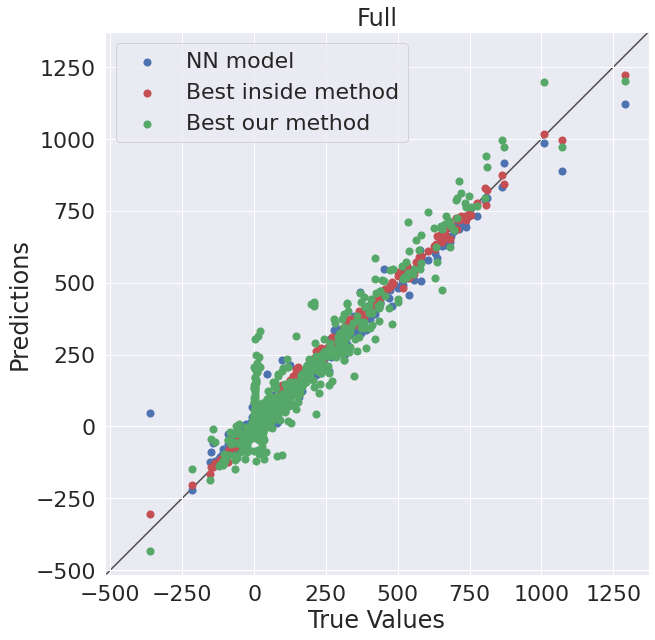

In [17]:
for setname in fullsetnames:
    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    y_pred = models_results[setname].y_pred 
    rmse = mean_squared_error(Y, y_pred, squared=False)
    r2 = r2_score(Y, y_pred)
    print("RMSE ", setname, " : %6.2f"%rmse)
    print("R2   ", setname, " : %6.2f"%r2)
    plt.clf()
    #plt.scatter(Y, y_pred)

    fig, ax = plt.subplots()
    #plt.scatter(Y, y_pred, c='b', s=30, label='NN model', \
    #            marker=".")
    #plt.scatter(Y, models_results[setname].y_pred_bestinsidemethod, \
    #            c='r', label='Best inside method',  \
    #                marker=".")
    #plt.scatter(Y, models_results[setname].y_pred_bestourmethod, \
    #            c='g', label='Best our method', \
    #                marker=".")
    ax.scatter(Y, y_pred, c='b', s=50, label='NN model')
    ax.scatter(Y, models_results[setname].y_pred_bestinsidemethod, \
                c='r', s=50, label='Best inside method')
    ax.scatter(Y, models_results[setname].y_pred_bestourmethod, \
               c='g', s=50, label='Best our method')
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend(loc="upper left")
    plt.title(setname)
    plt.show()